In [41]:
import os
import cv2
import numpy as np
import pandas as pd
import threading
from queue import Queue
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

watermark_DIR = "watermark\\WaterM.png"

if not os.path.exists('watermarkdata.csv'):
    pd.DataFrame(columns=['METRIC','PSNR','SSIM','CC','ATTACK','DATASET']).to_csv('watermarkdata.csv', index=False)

In [42]:
def toprint(df,attackNAME):
    columns_to_analyze = df.columns[1:]  # Start from the 2nd column (Column2)
    max_values = df[columns_to_analyze].max()
    min_values = df[columns_to_analyze].min()
    mean_values = df[columns_to_analyze].mean()
    
    # Create a new DataFrame with max, min, and mean values
    output_df = pd.DataFrame({
        'Metric': ['Max', 'Min', 'Mean'],
        'PSNR': [max_values['PSNR'], min_values['PSNR'], mean_values['PSNR']],
        'SSIM': [max_values['SSIM'], min_values['SSIM'], mean_values['SSIM']],
        'CC': [max_values['CC'], min_values['CC'], mean_values['CC']]
    })
    
    # Add a new column 'Dataset' with value 'newdata01'
    output_df['ATTACK'] = attackNAME
    output_df['DATASET'] = "sipi" #___________________________________change dataset name here____________________________
    output_df.to_csv('watermarkdata.csv', mode='a', header=False, index=False)

    return output_df

In [43]:

    
def imperceptibility(images_DIR):


    def calculate_metrics(original_image, water, queue):

        psnr_value = psnr(original_image, water)
        ssim_value = ssim(original_image, water, channel_axis=-1)
        correlation = np.corrcoef(original_image.flatten(), water.flatten())[0, 1]

        queue.put((image_path, psnr_value, ssim_value, correlation))

        return psnr_value, ssim_value, correlation



    def get_image_names(folder_path):
    
        image_names = []
        for filename in os.listdir(folder_path):
            image_names.append(filename)
        return image_names


    
    
    image_names = get_image_names(images_DIR)
    data = {'Image Name': [], 'PSNR': [], 'SSIM': [], 'CC': []}
    queue = Queue() 
    threads = [] 


    for imgname in image_names:
        image_path = images_DIR + imgname
        image = cv2.imread(image_path)
        water = cv2.imread(watermark_DIR)

        # create a thread for each image pair and pass the queue as an argument
        thread = threading.Thread(target=calculate_metrics, args=(image, water, queue))
        threads.append(thread) # add the thread to the list
        thread.start() # start the thread

    for thread in threads:
        thread.join() # wait for all threads to finish

    while not queue.empty(): # get the results from the queue
        image_path, psnr_value, ssim_value, correlation = queue.get()

        data['Image Name'].append(os.path.basename(image_path))
        data['PSNR'].append(psnr_value)
        data['SSIM'].append(ssim_value)
        data['CC'].append(correlation)



    df = pd.DataFrame(data)


    print(df)
    return df

In [44]:
%%time

images_DIR = "extracted\\"
df=imperceptibility(images_DIR)
toprint(df,'attack')


                                         Image Name       PSNR      SSIM  \
0  extracted_from_watermarked_image_image11sipi.png  40.579850  0.985373   
1  extracted_from_watermarked_image_image11sipi.png  31.805532  0.948656   
2  extracted_from_watermarked_image_image11sipi.png  40.678103  0.984818   

         CC  
0  0.999793  
1  0.998422  
2  0.999798  
CPU times: total: 78.1 ms
Wall time: 77 ms


,Metric,PSNR,SSIM,CC,ATTACK,DATASET
0,Max,40.678103,0.985373,0.999798,attack,sipi
1,Min,31.805532,0.948656,0.998422,attack,sipi
2,Mean,37.687828,0.972949,0.999337,attack,sipi


In [45]:
df.to_csv('fileWATER.csv')

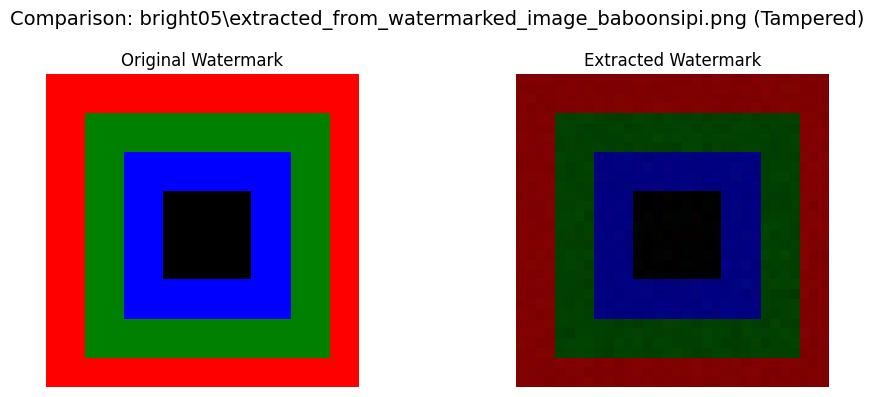

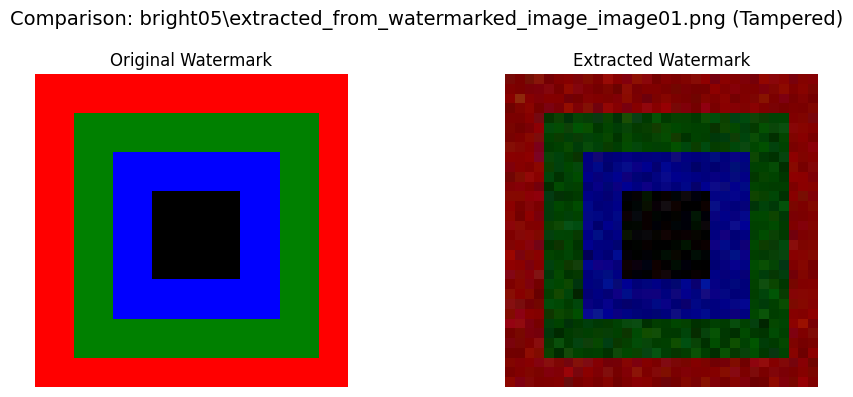

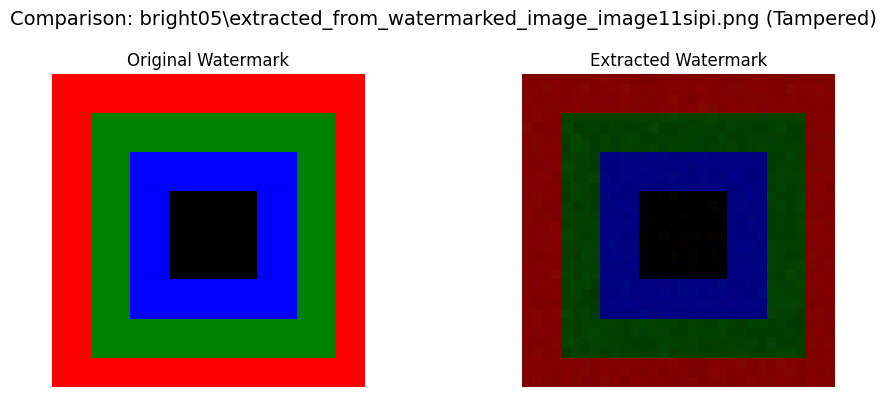

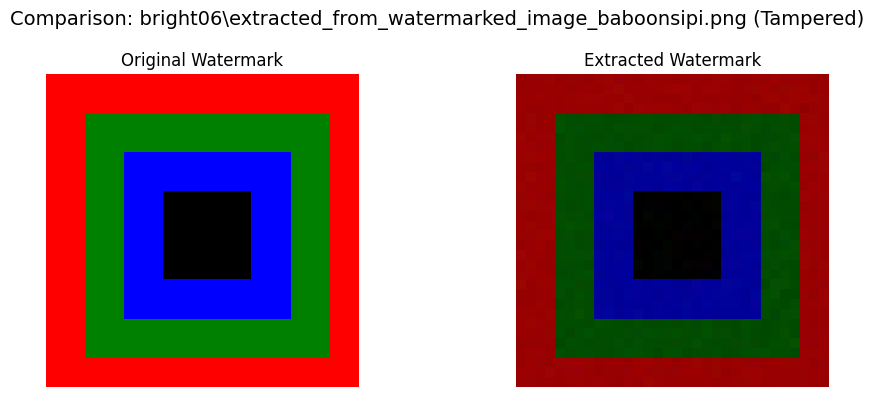

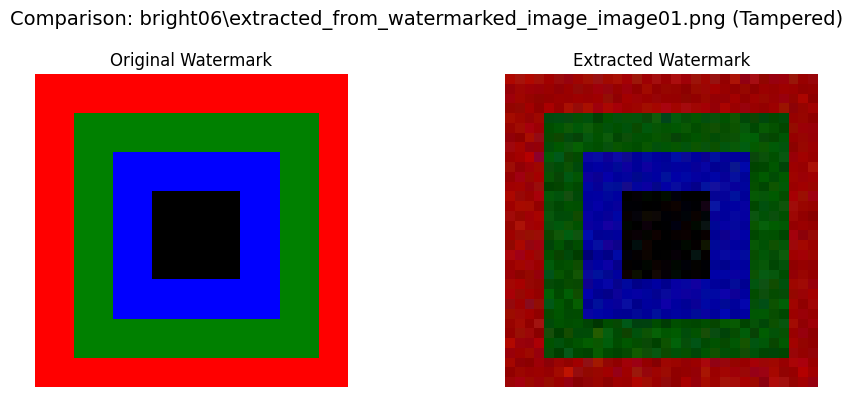

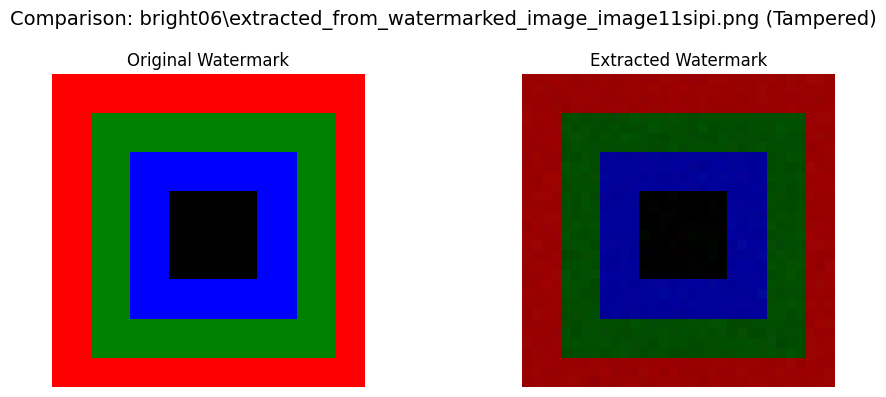

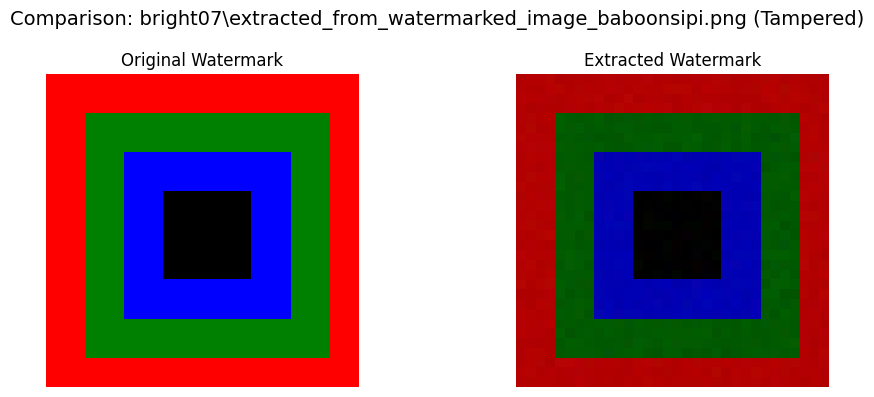

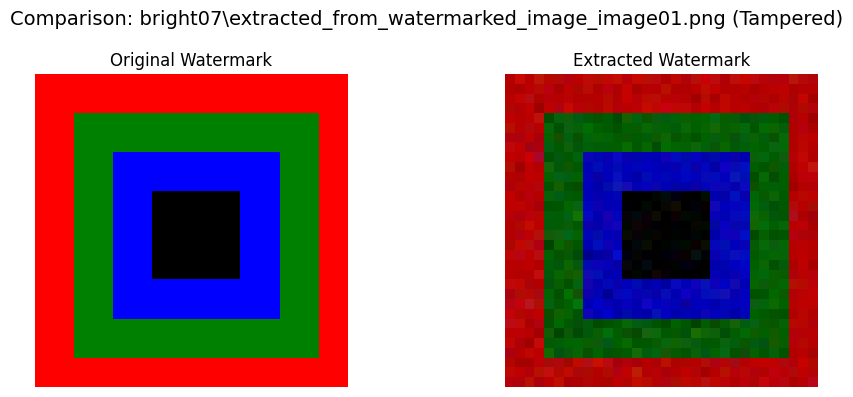

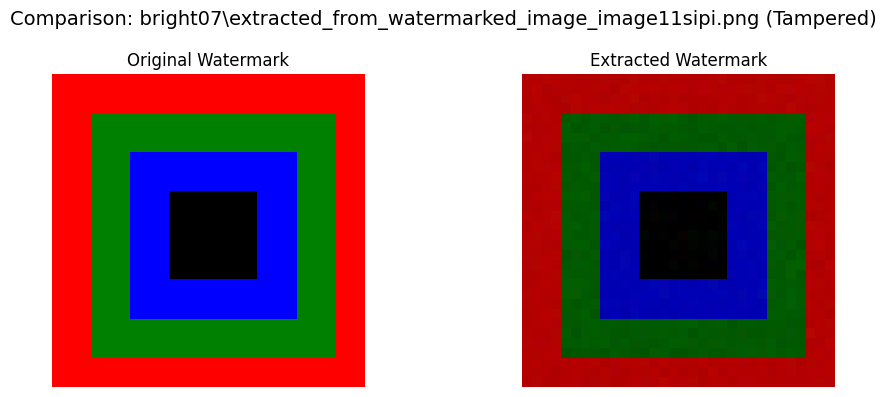

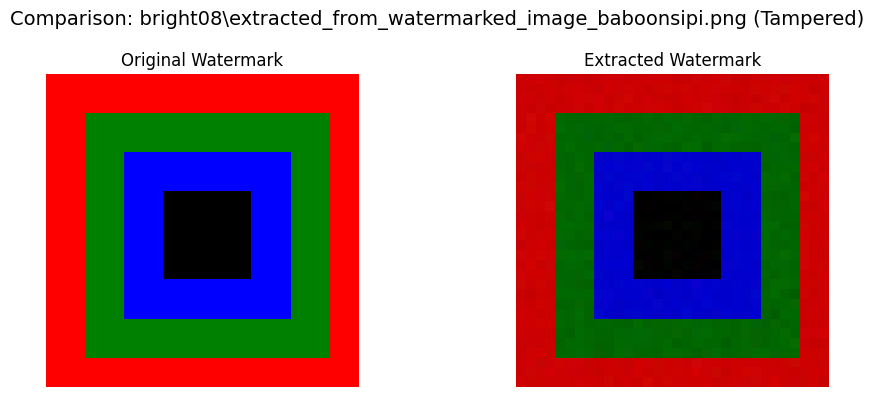

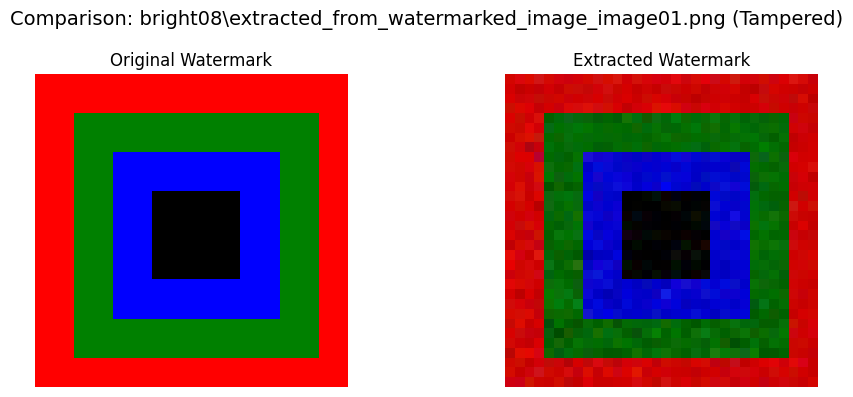

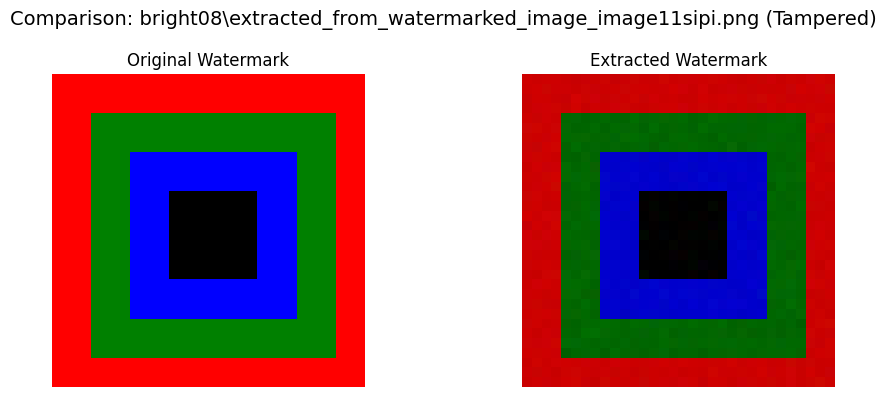

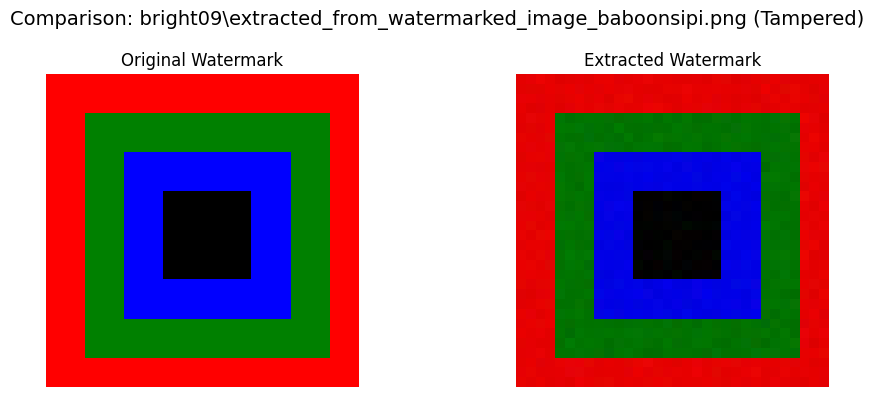

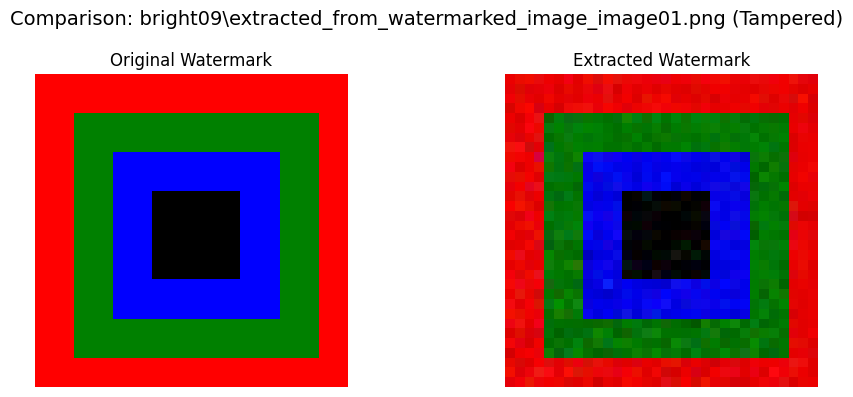

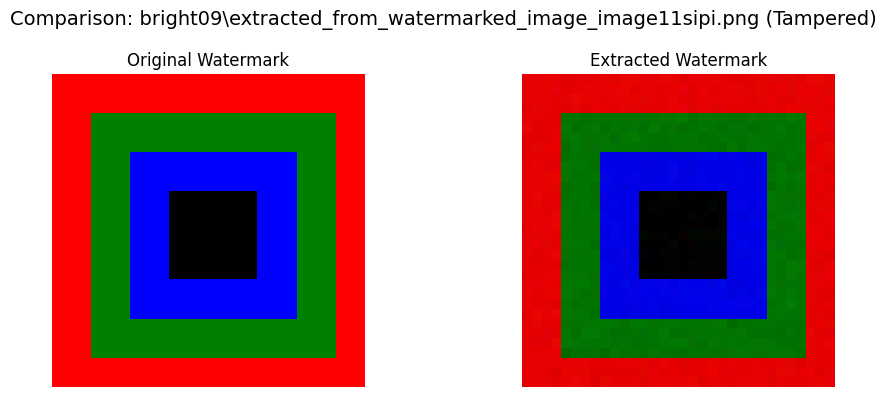

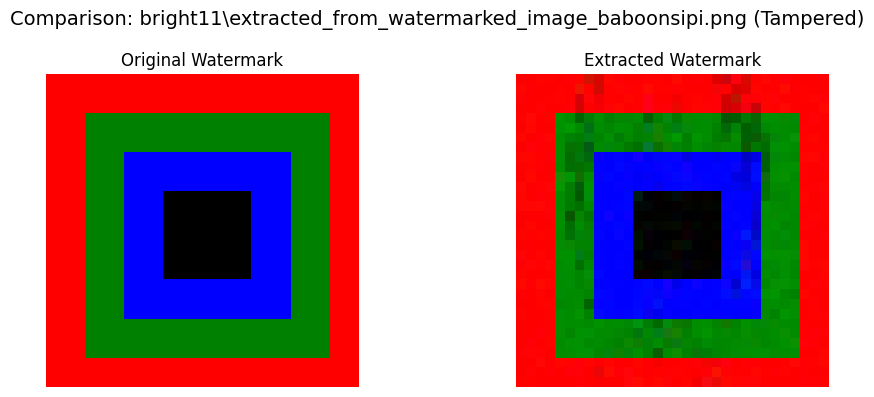

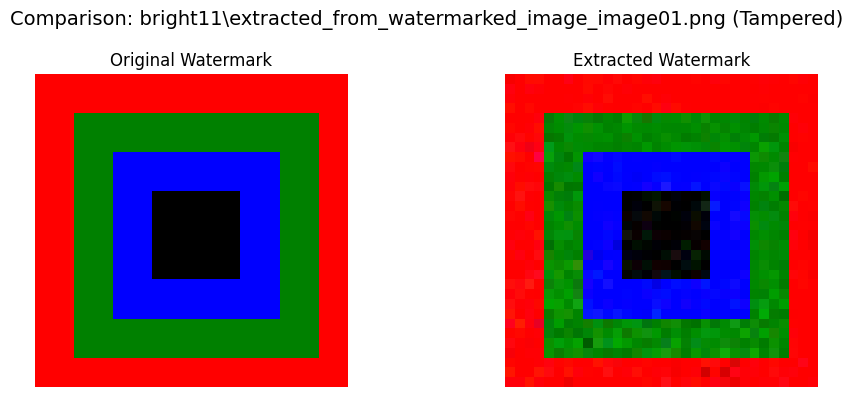

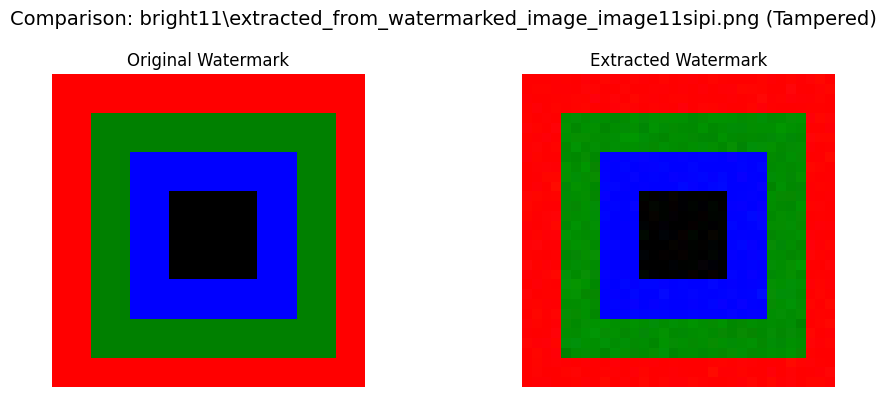

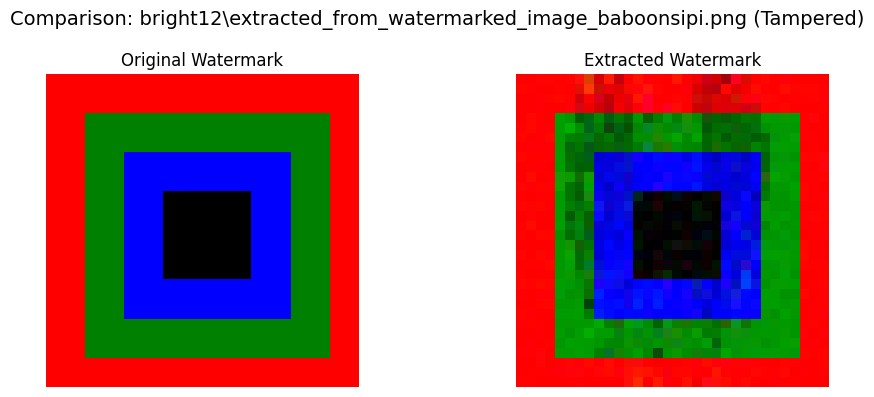

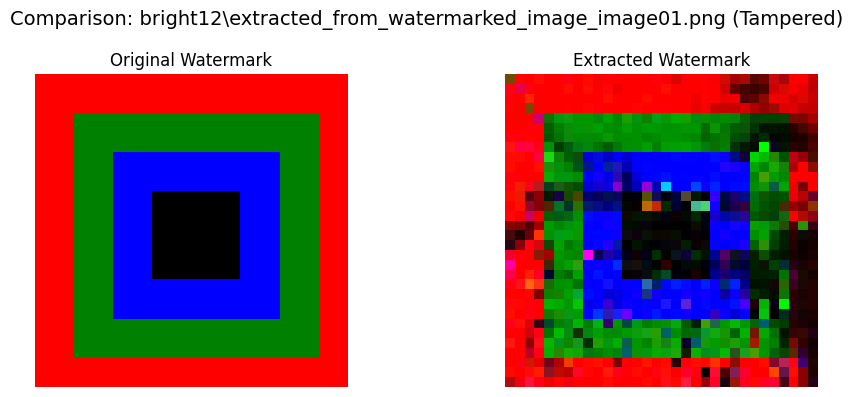

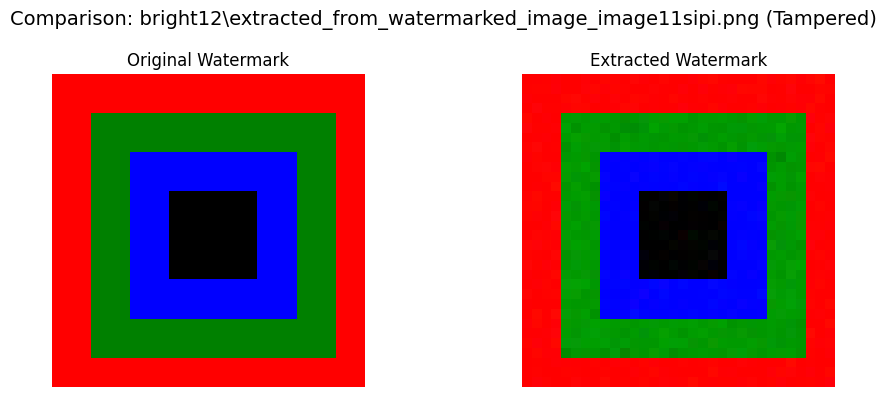

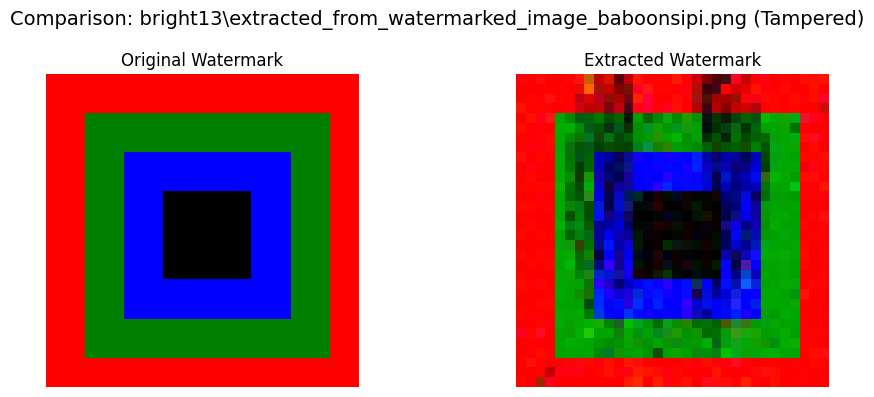

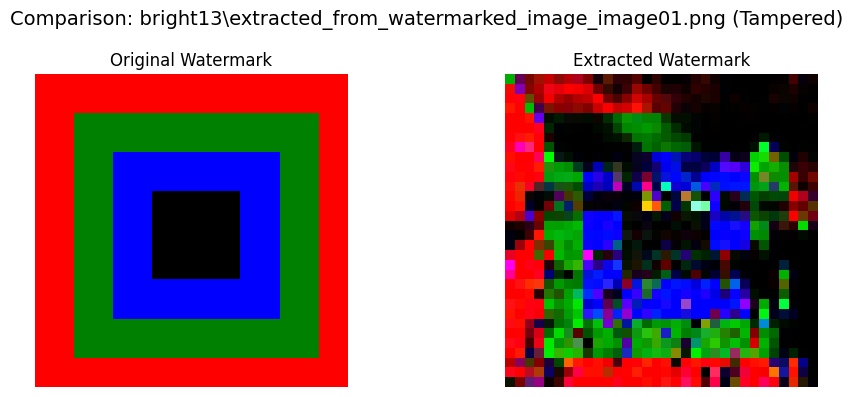

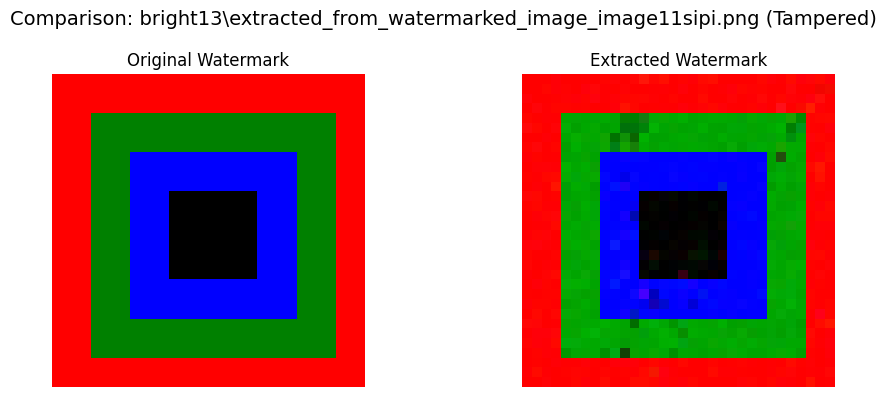

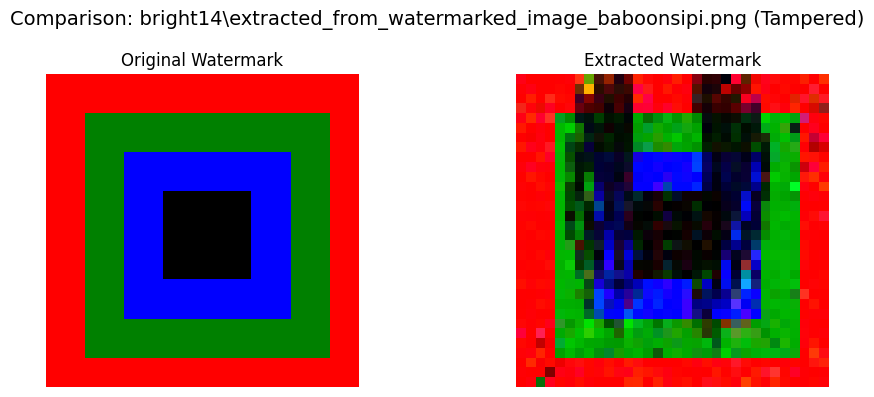

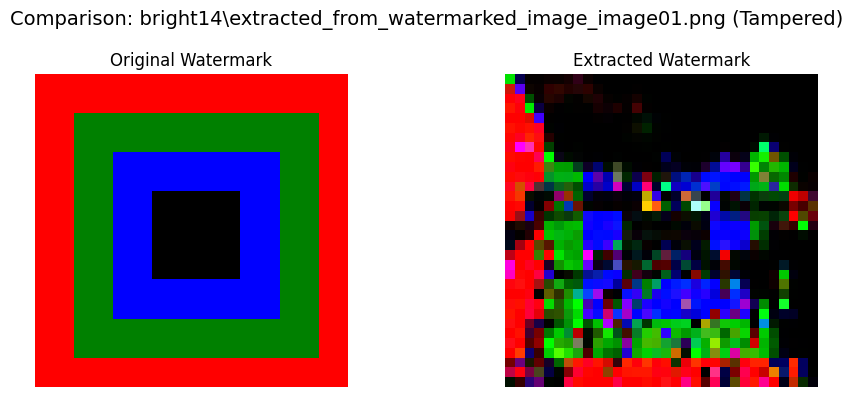

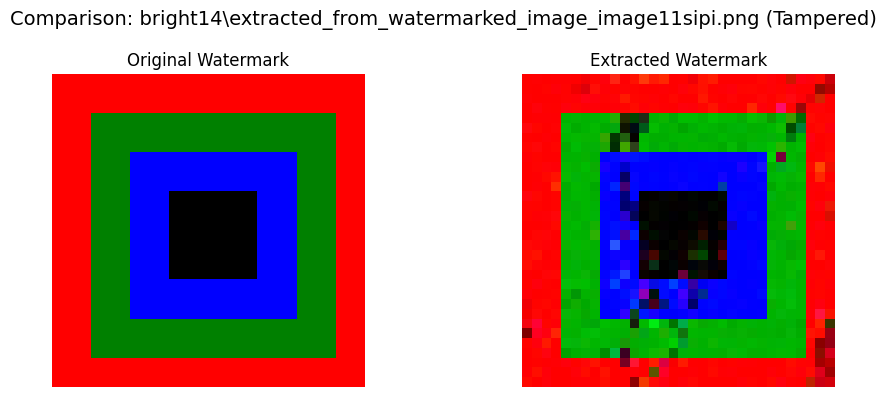

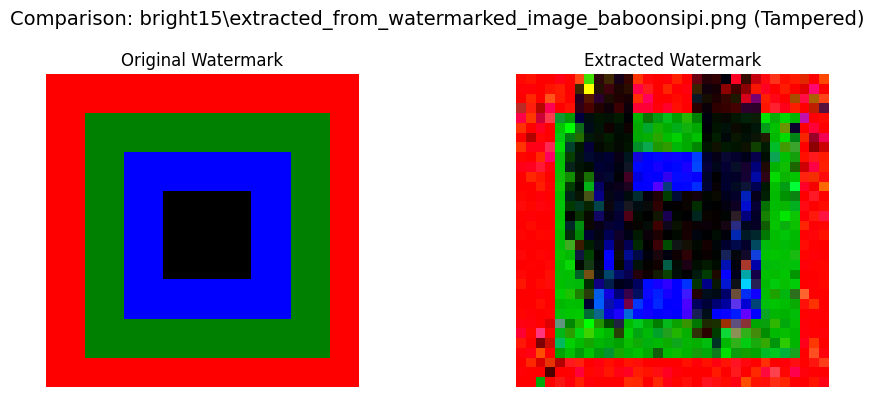

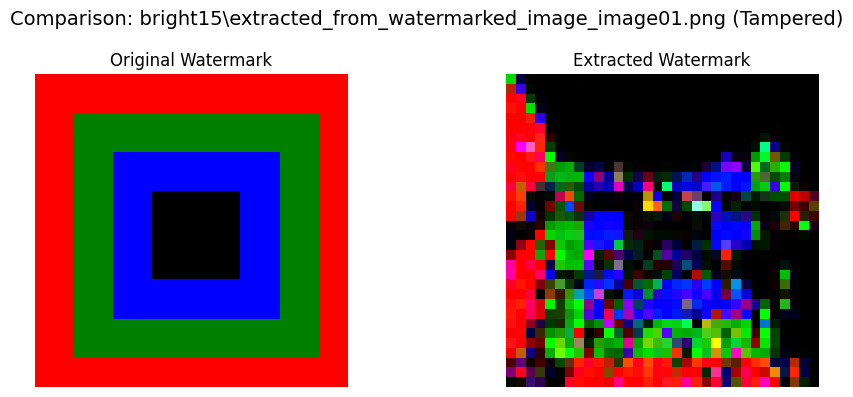

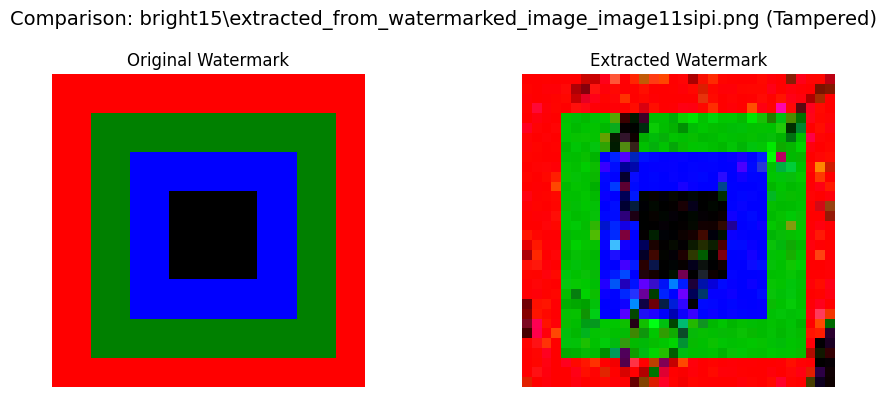

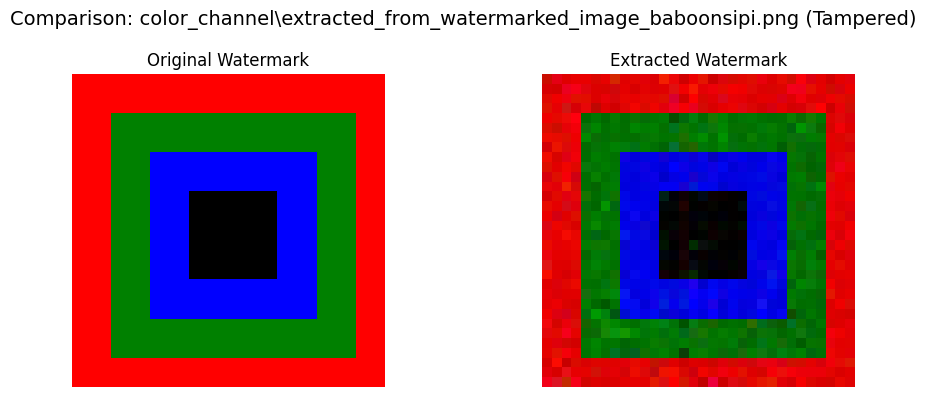

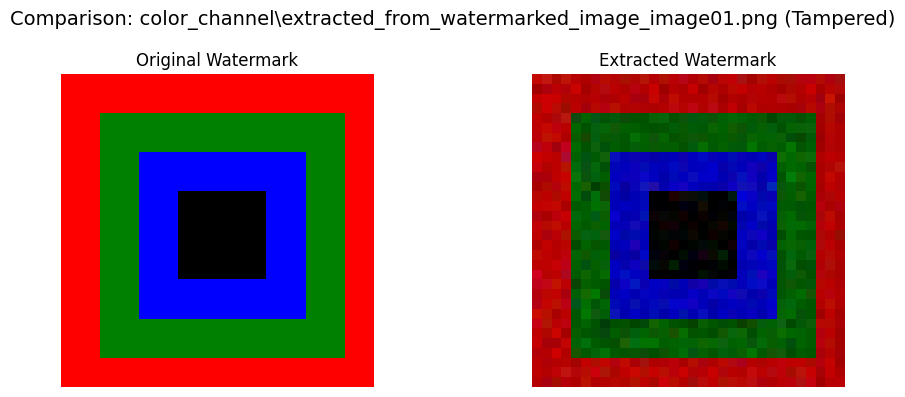

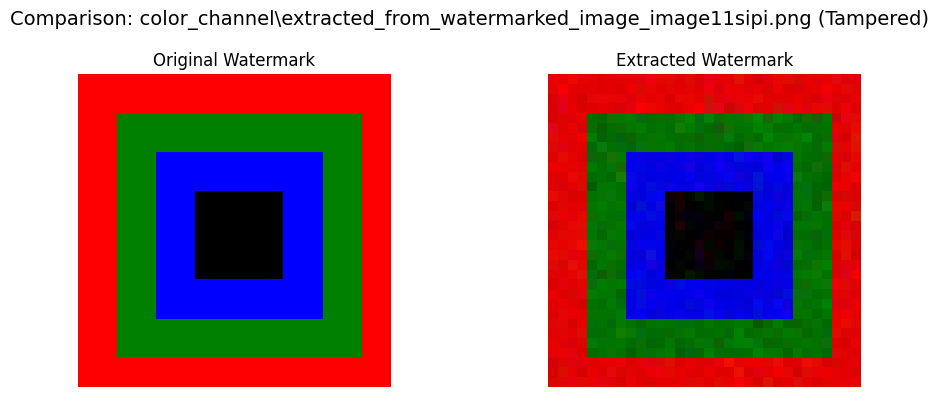

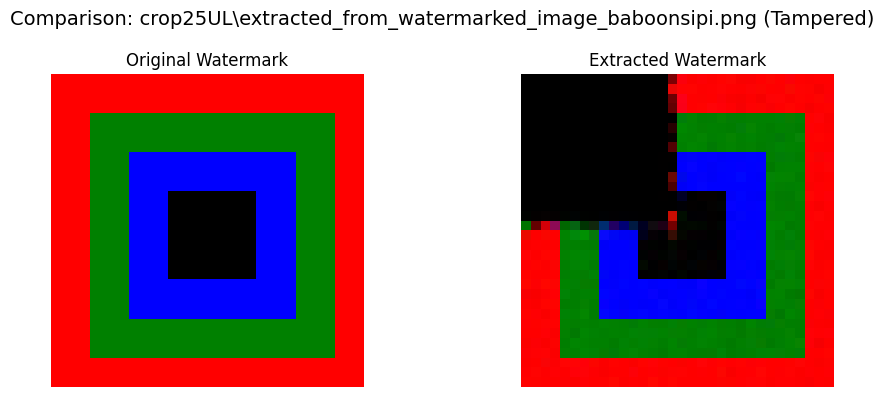

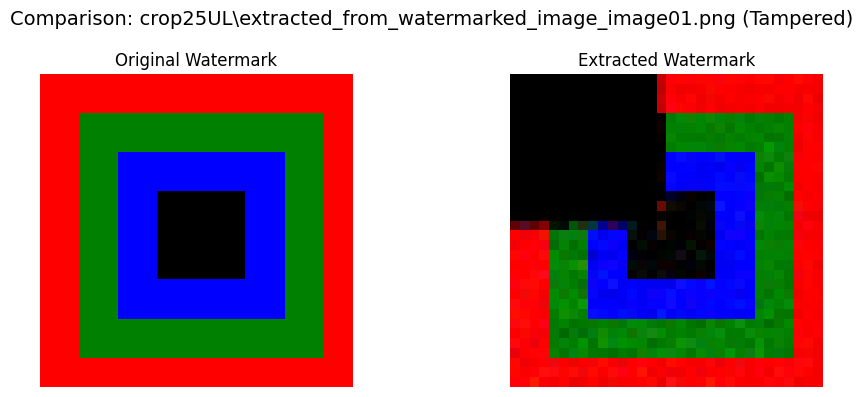

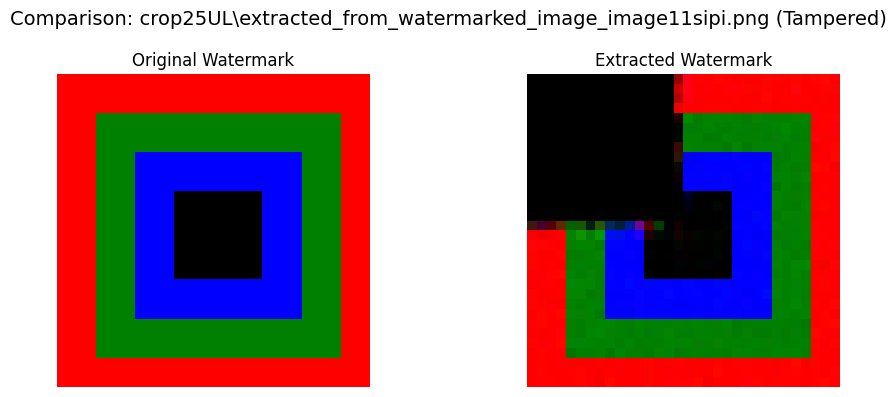

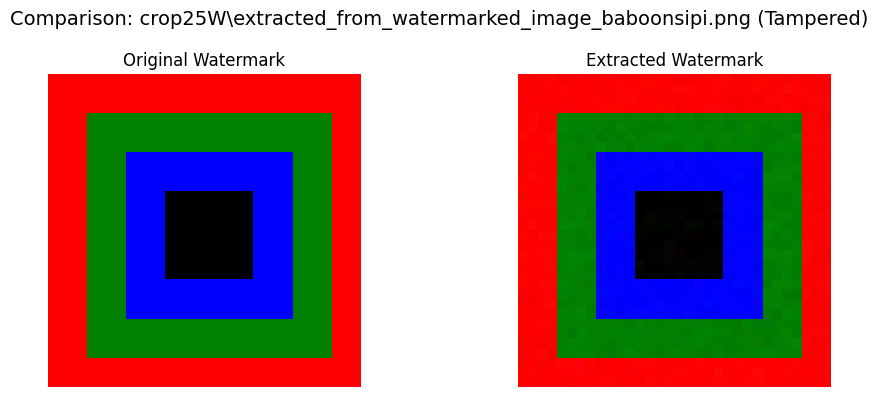

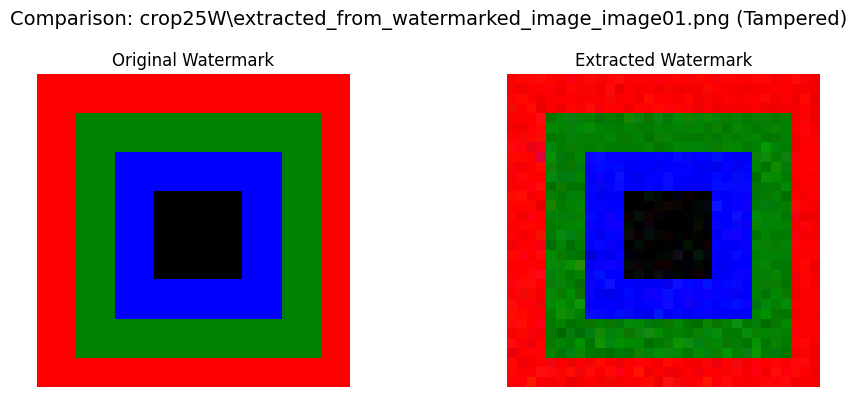

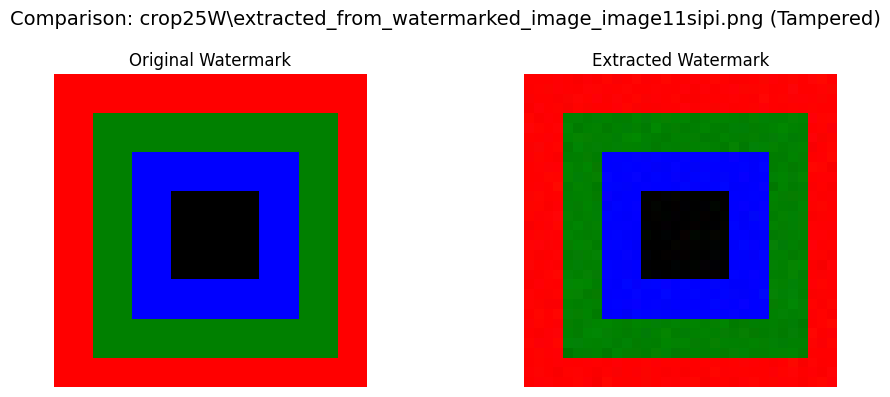

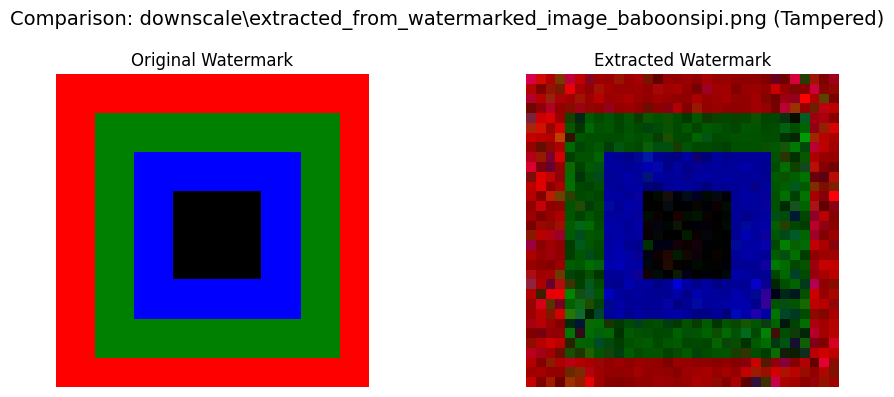

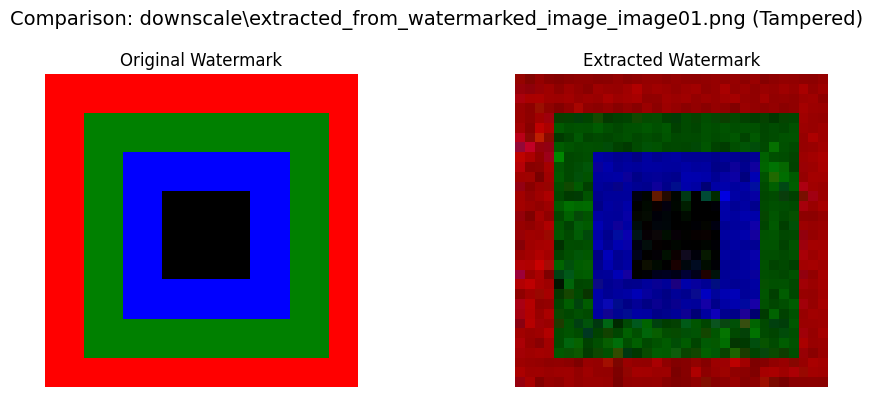

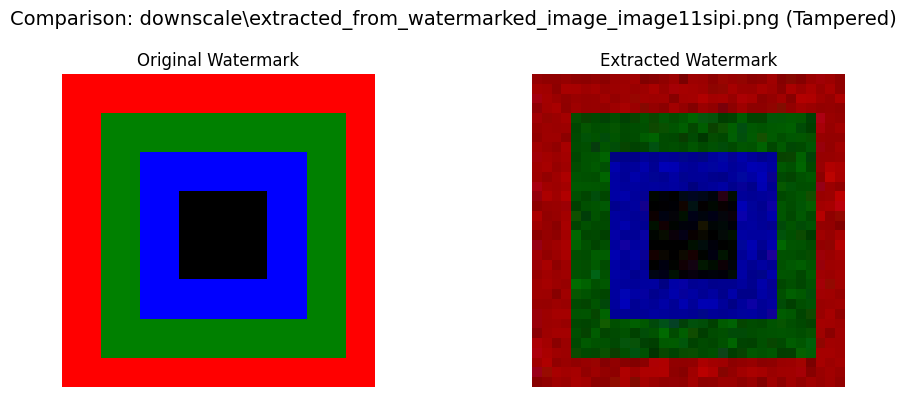

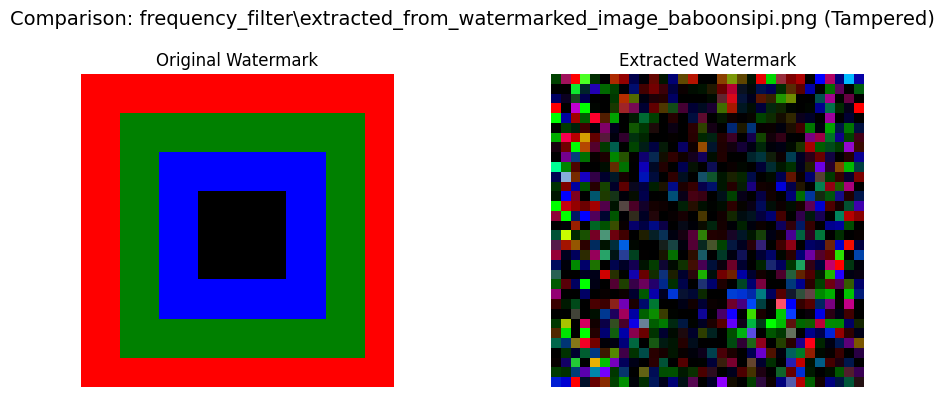

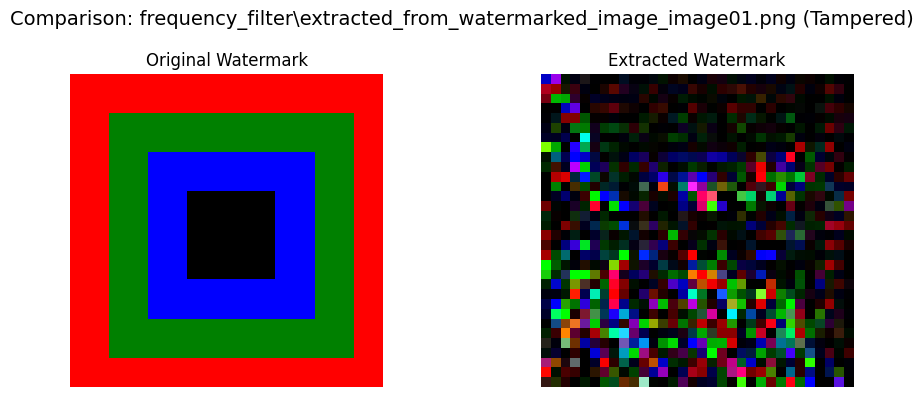

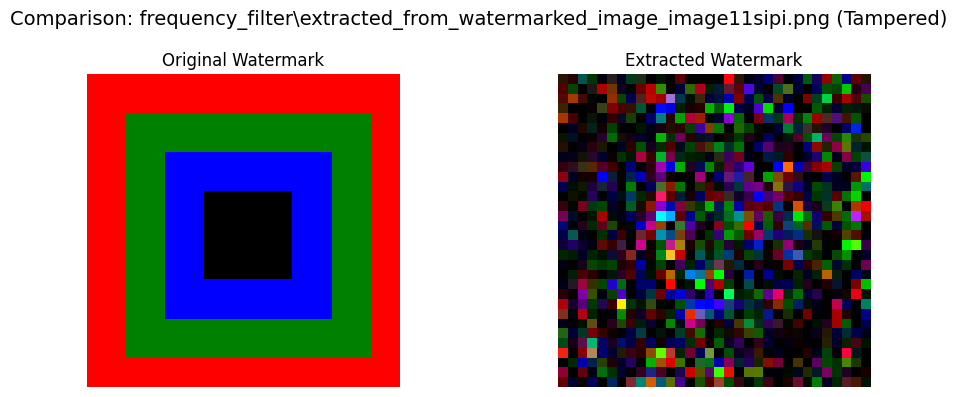

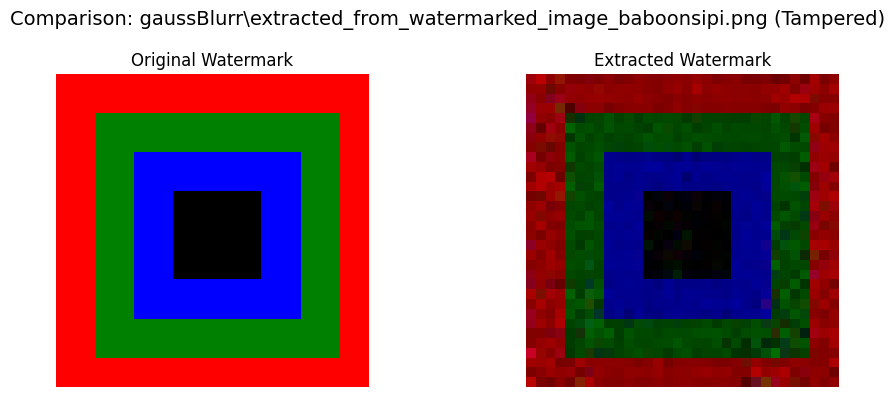

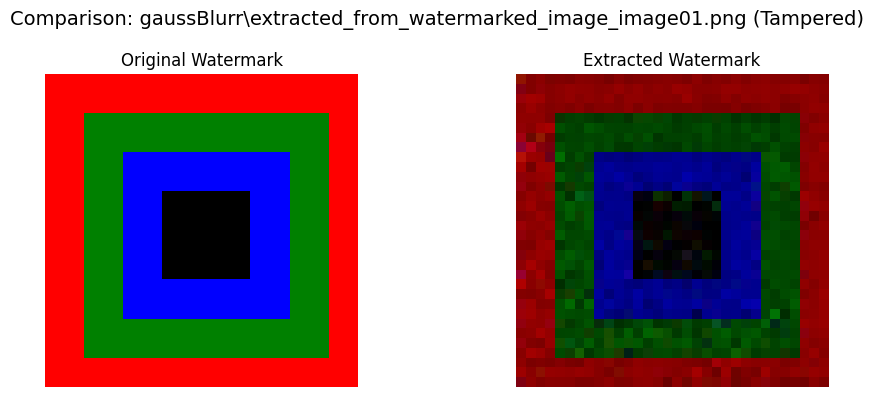

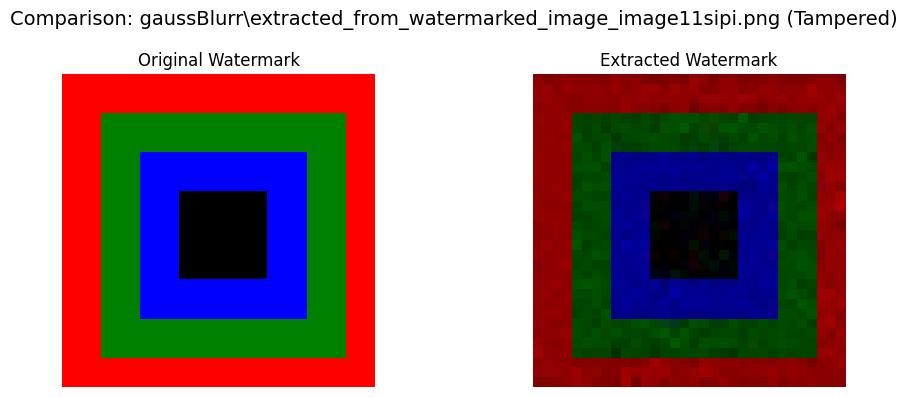

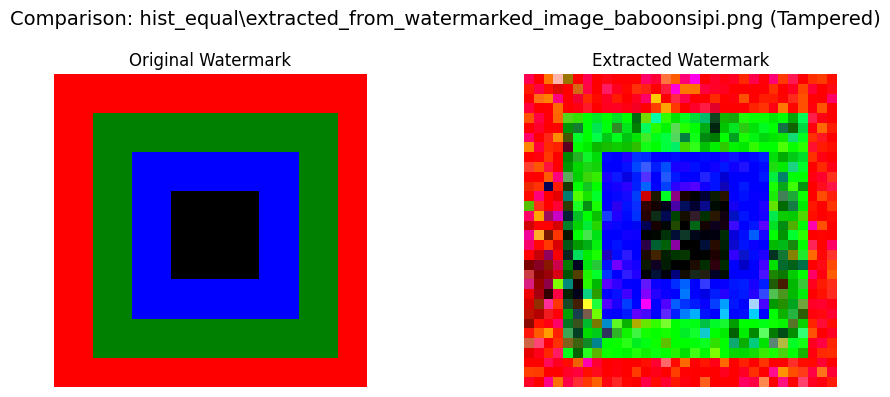

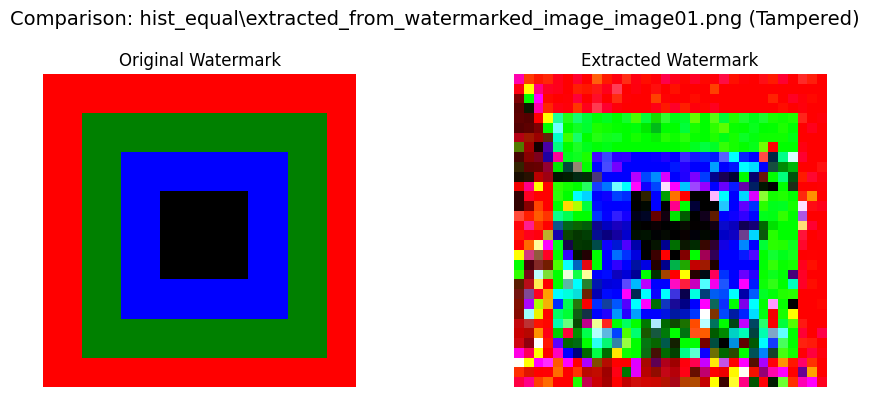

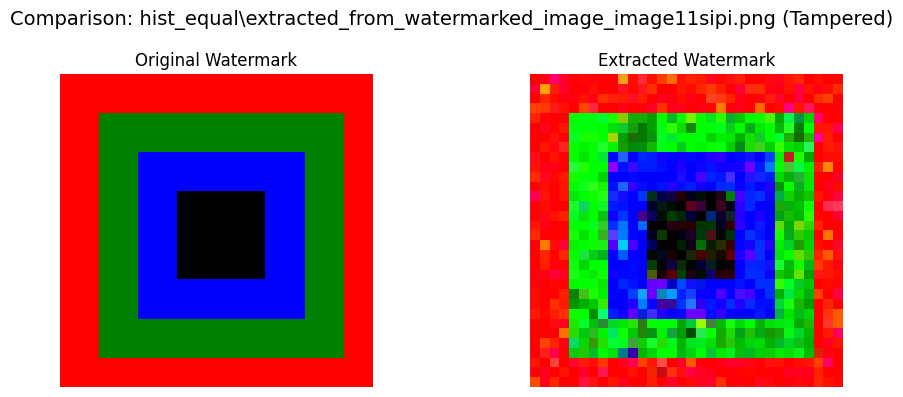

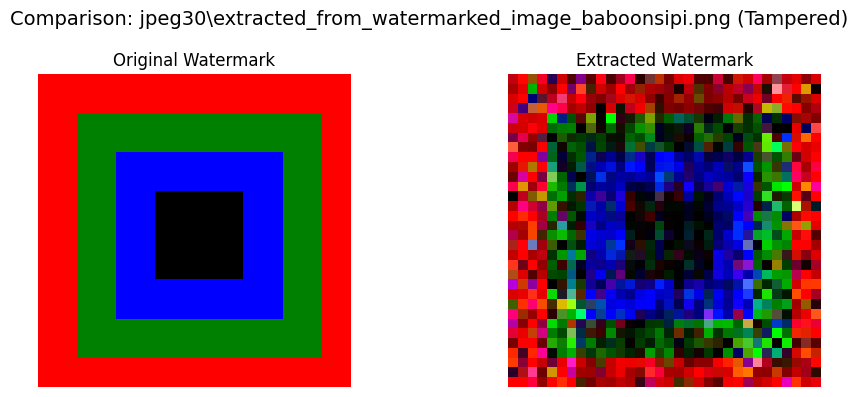

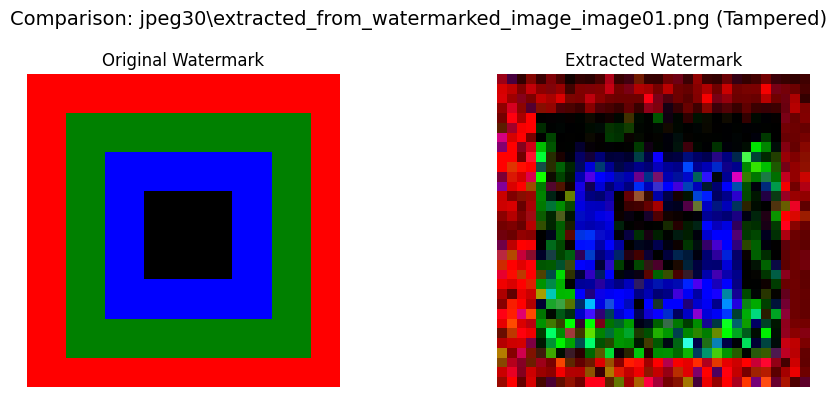

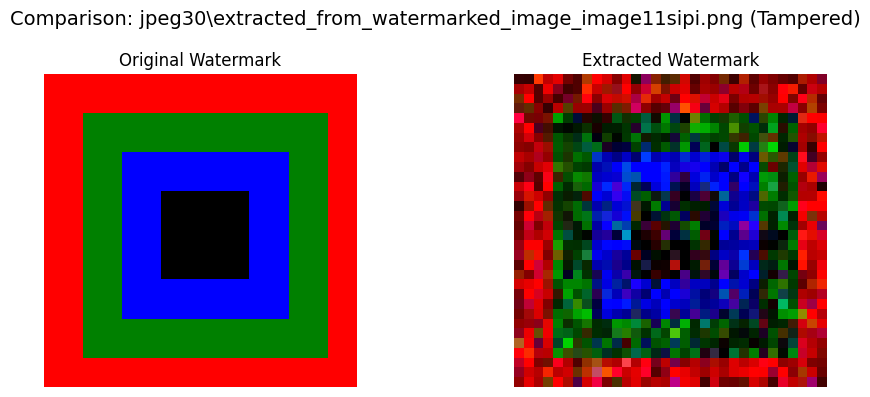

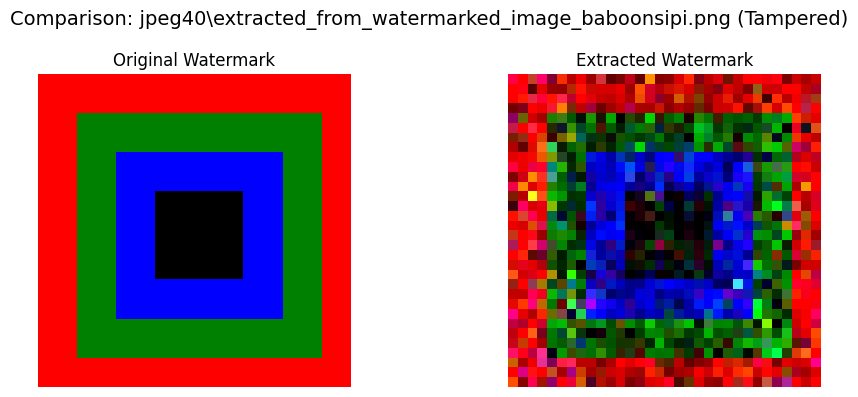

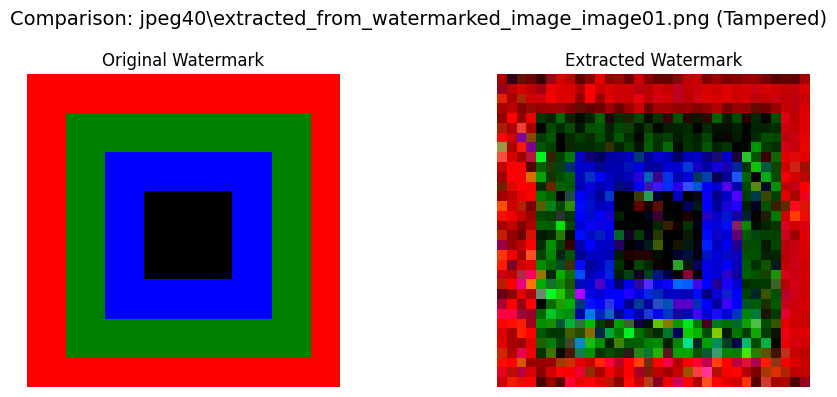

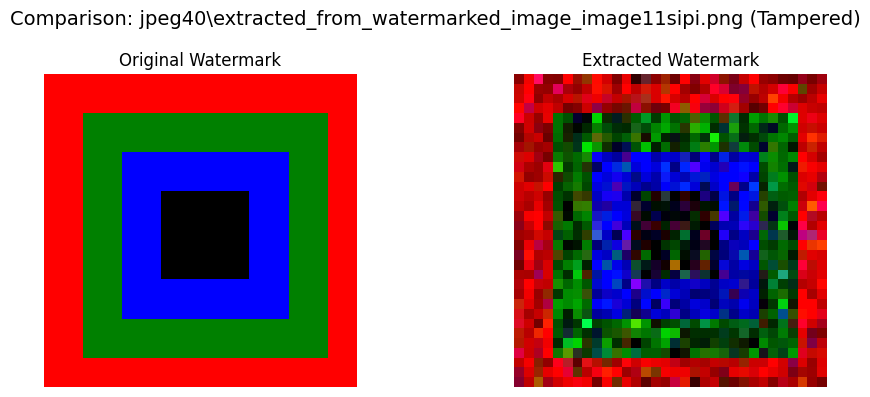

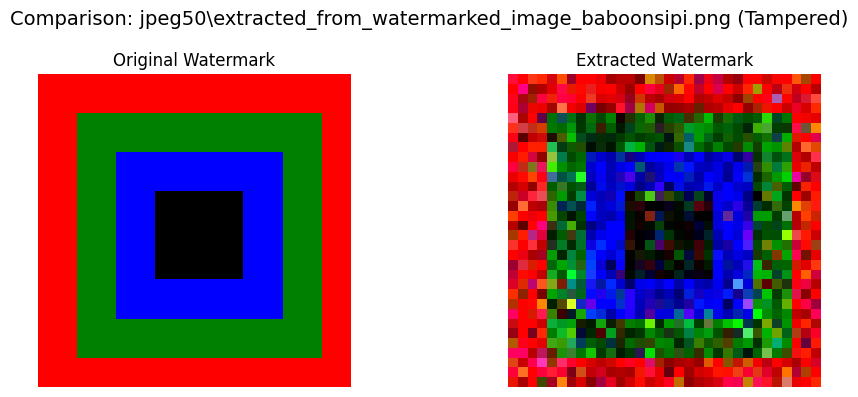

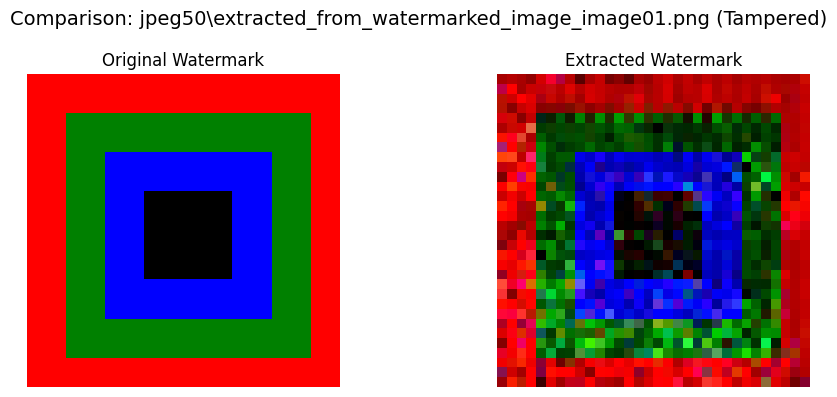

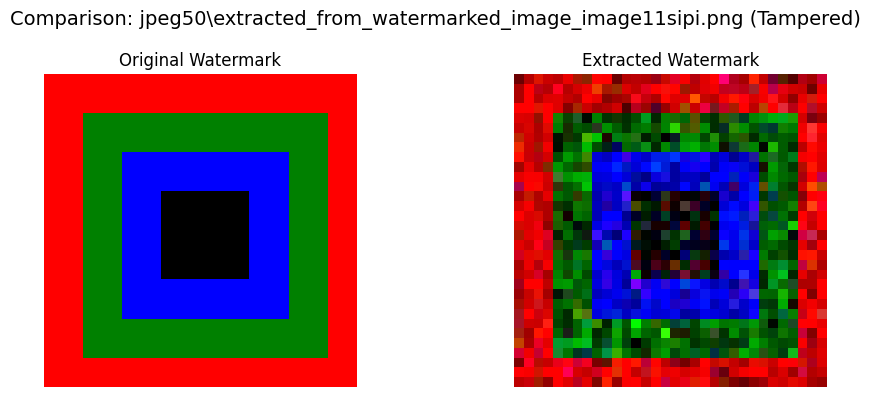

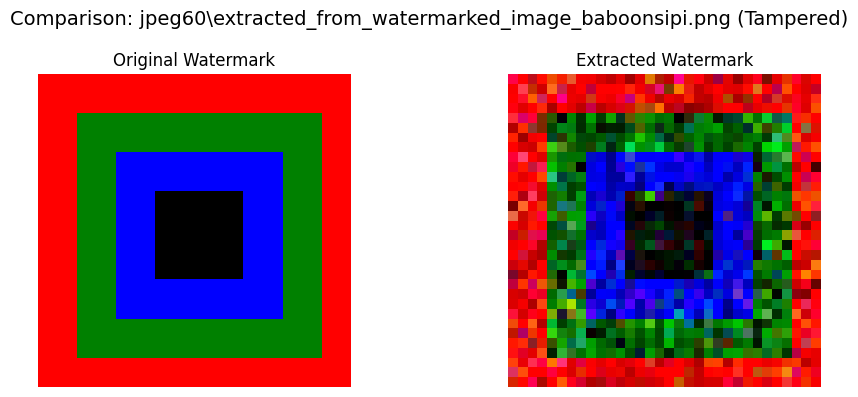

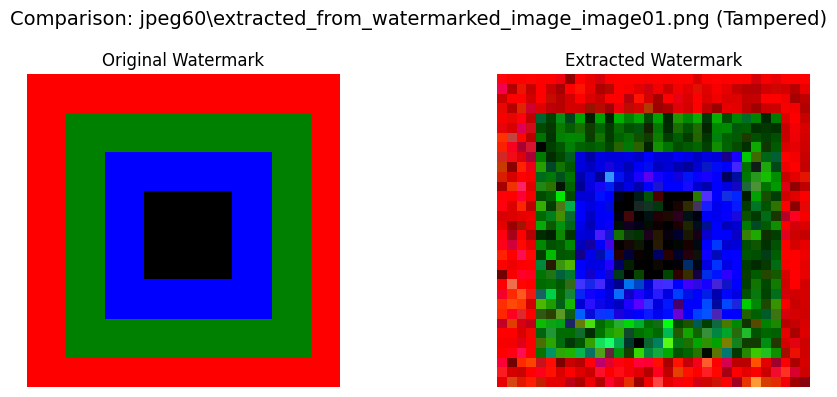

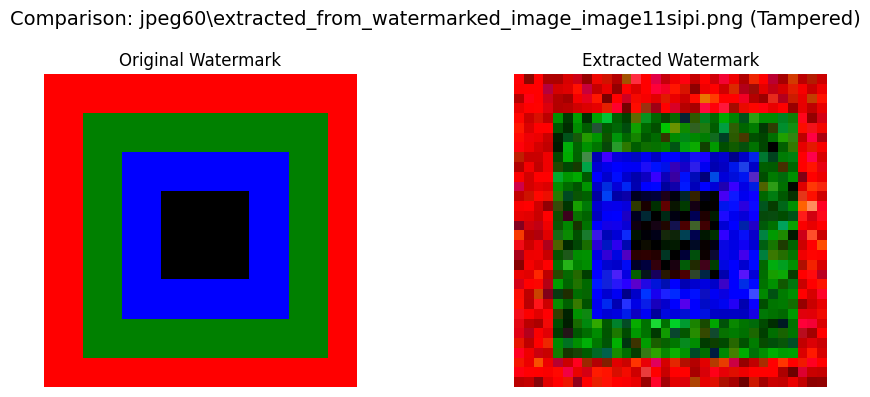

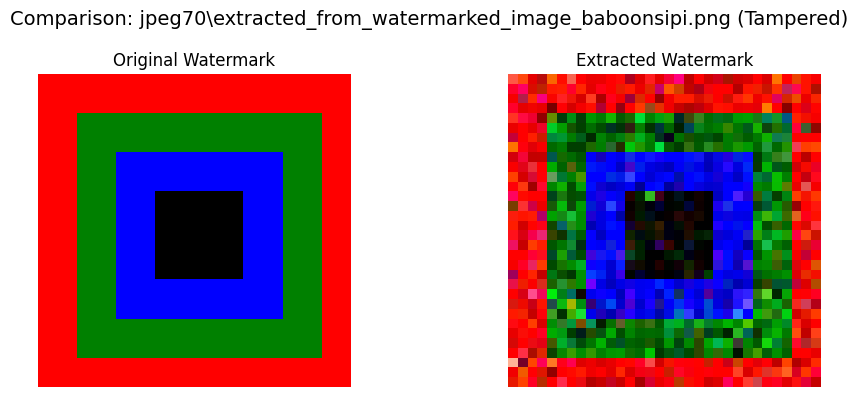

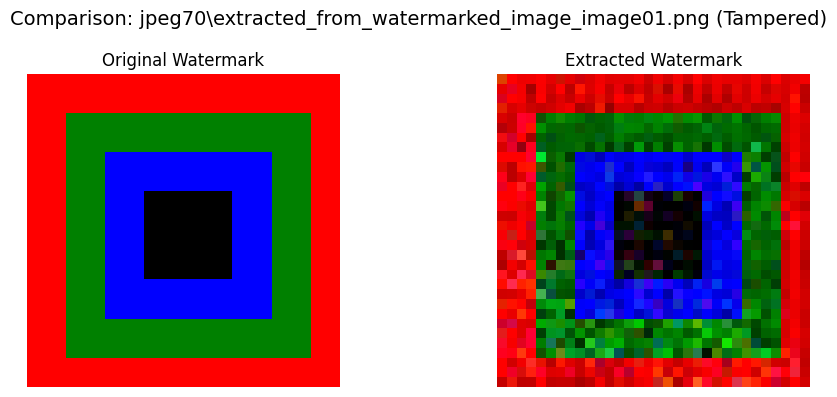

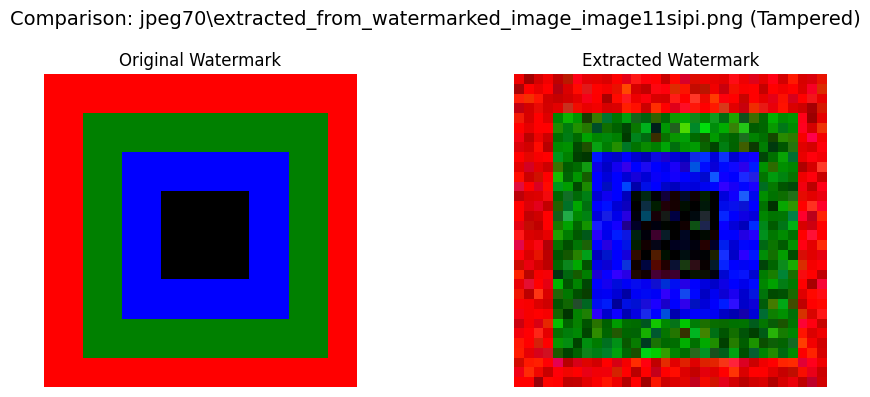

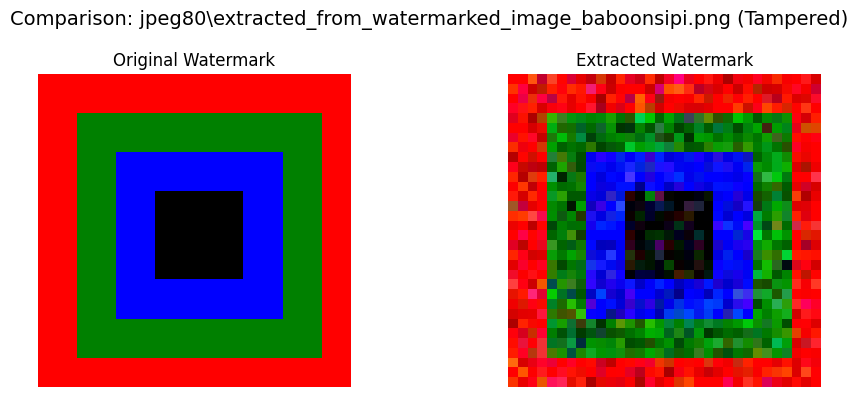

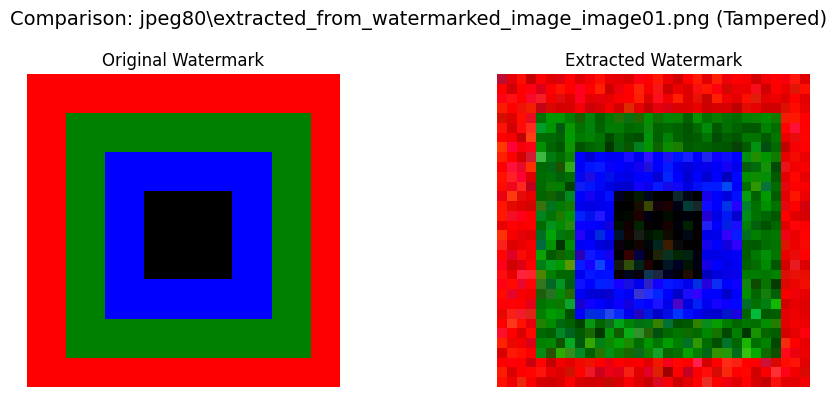

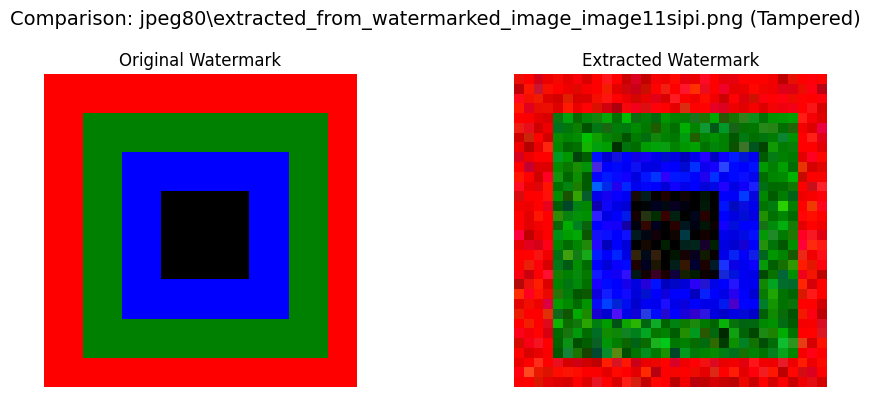

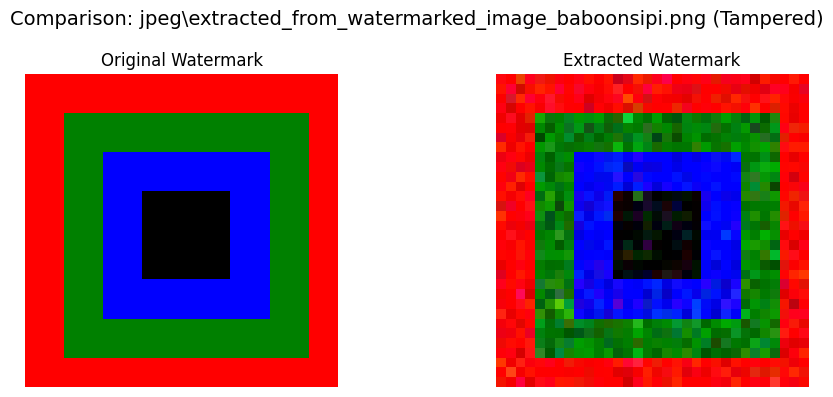

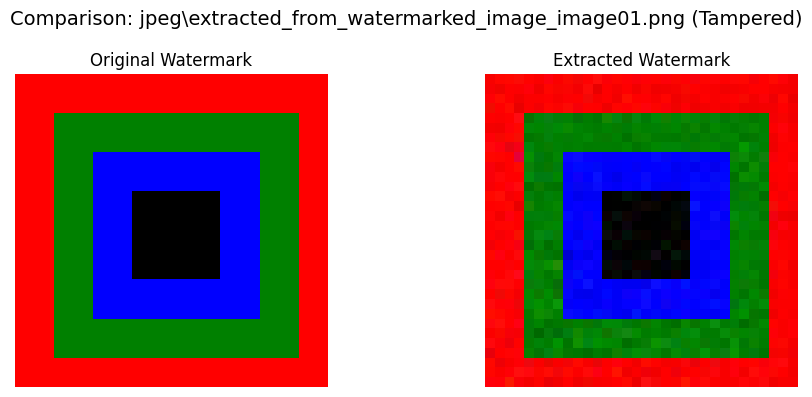

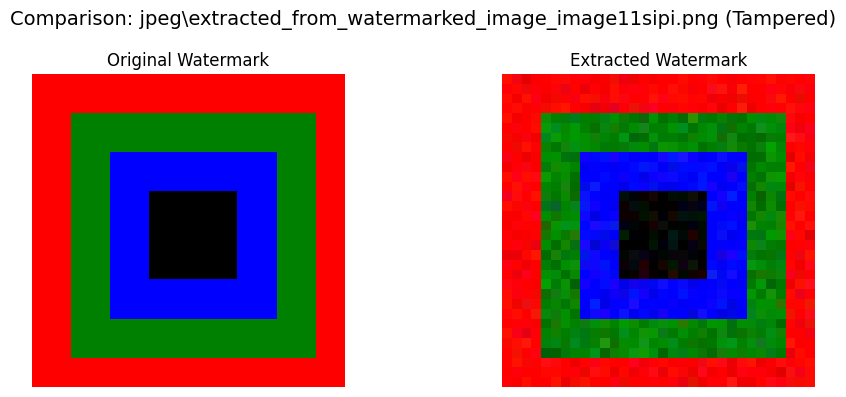

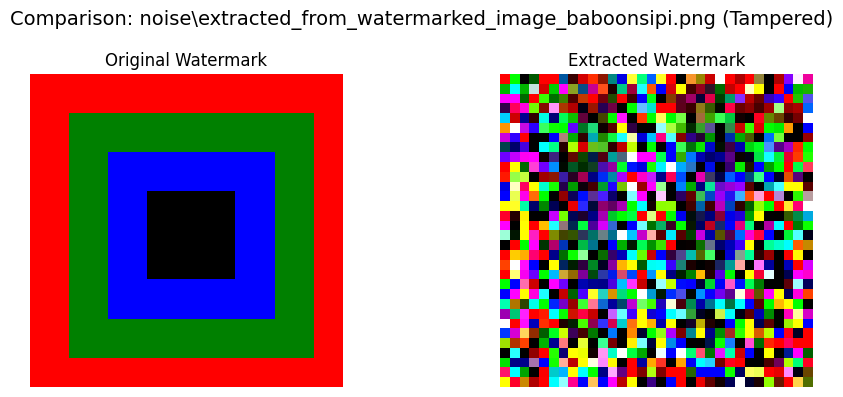

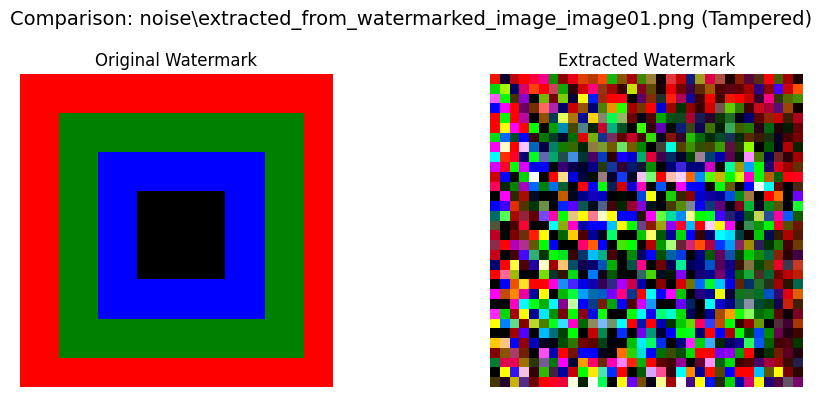

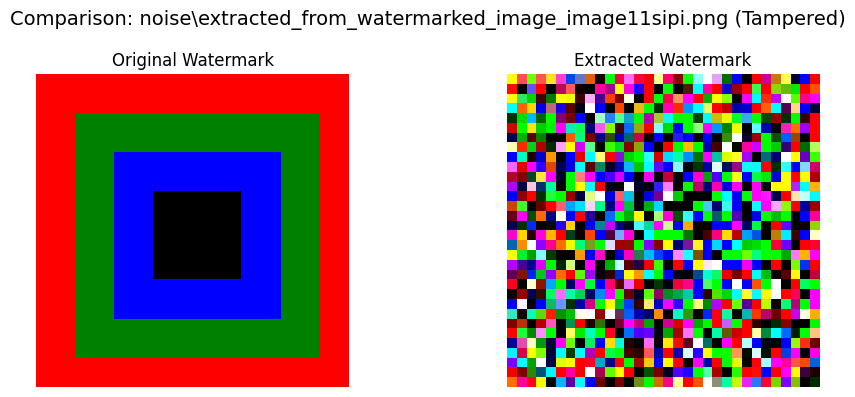

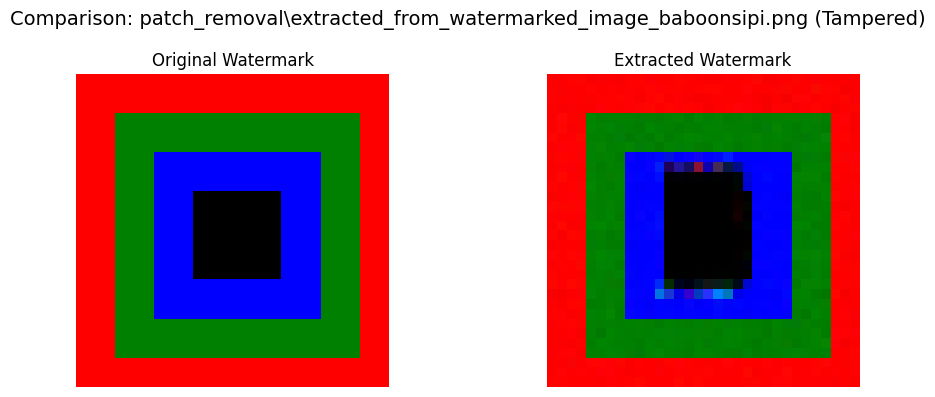

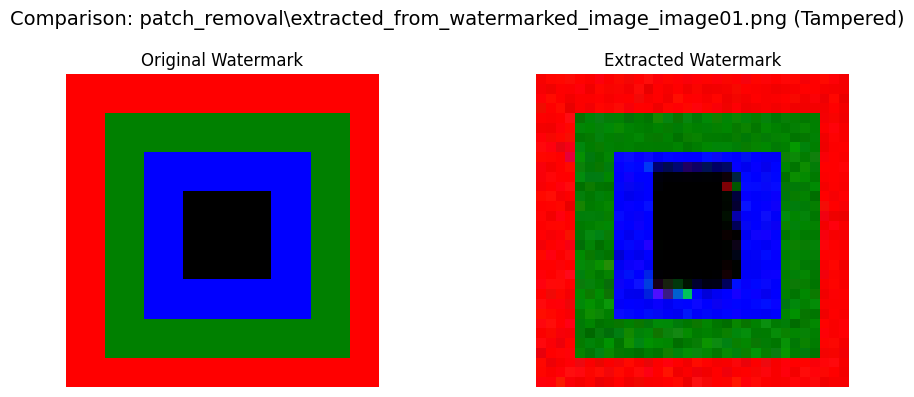

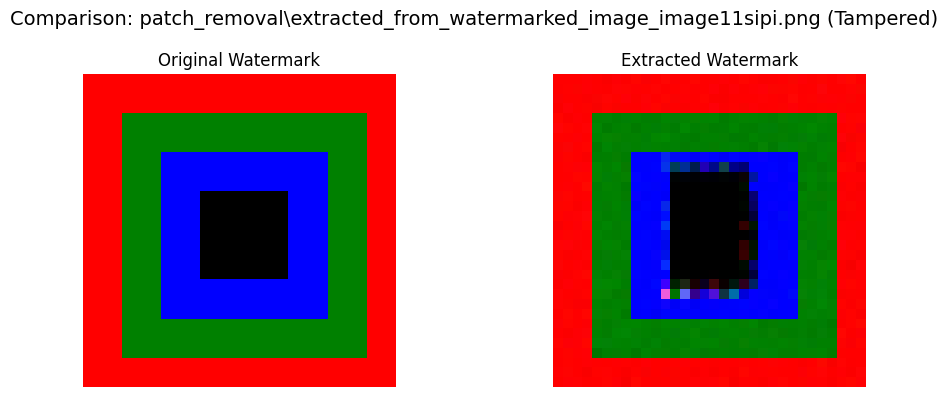

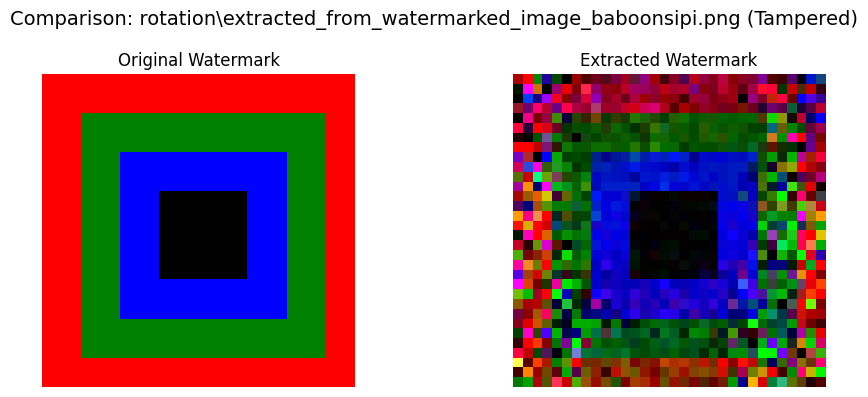

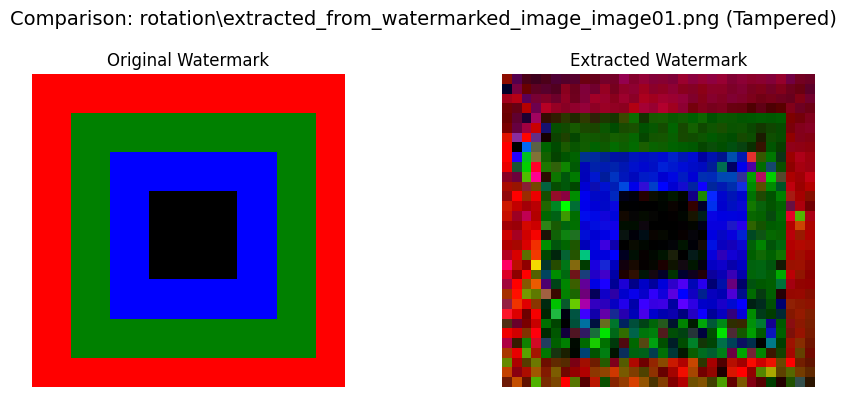

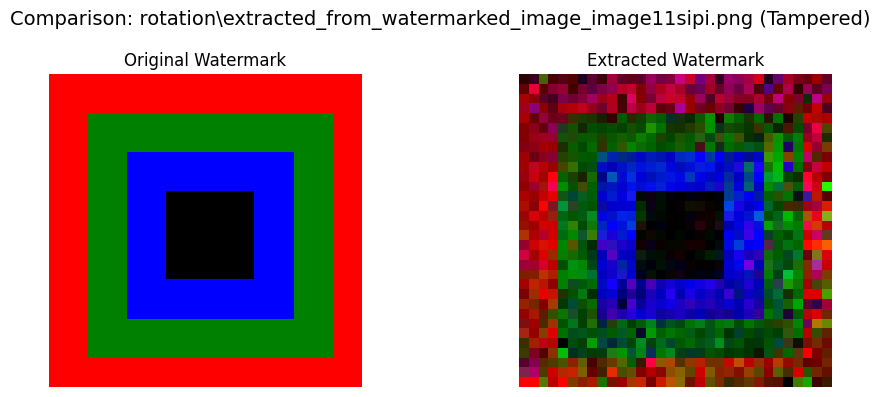

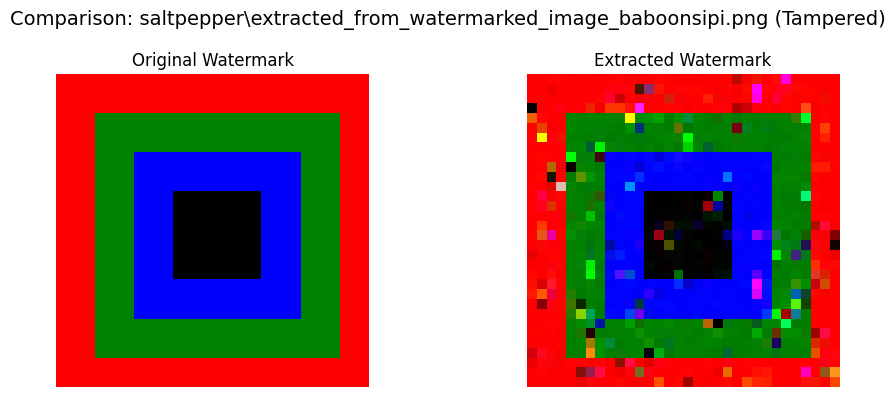

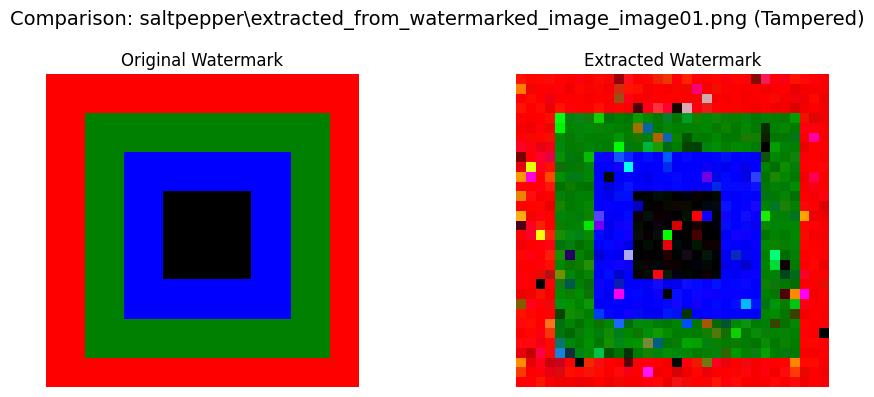

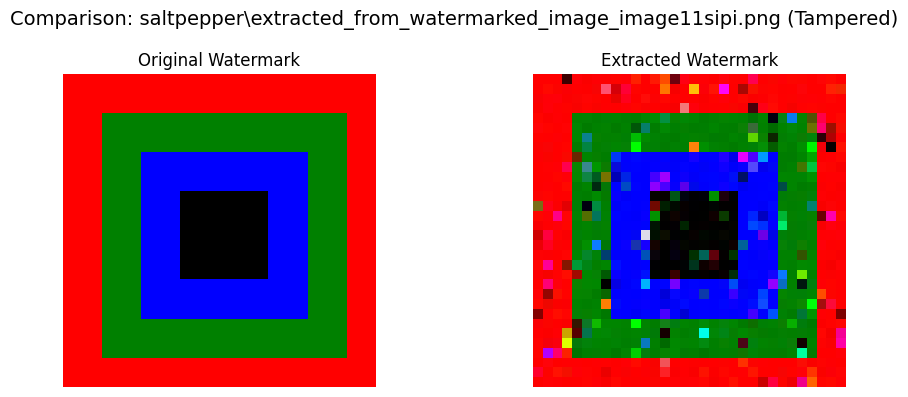

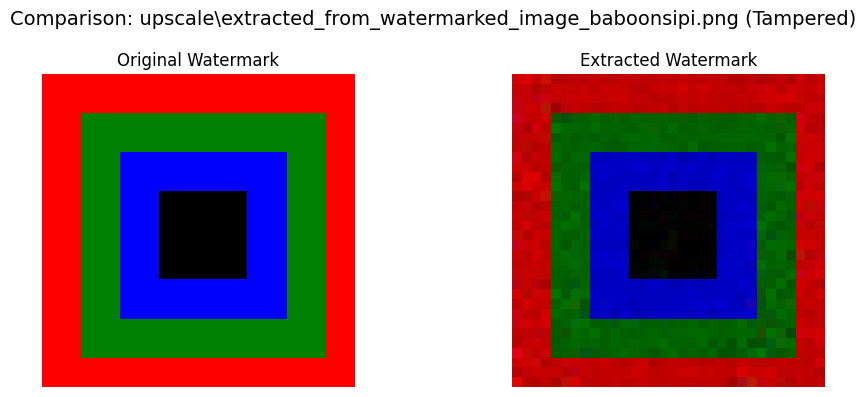

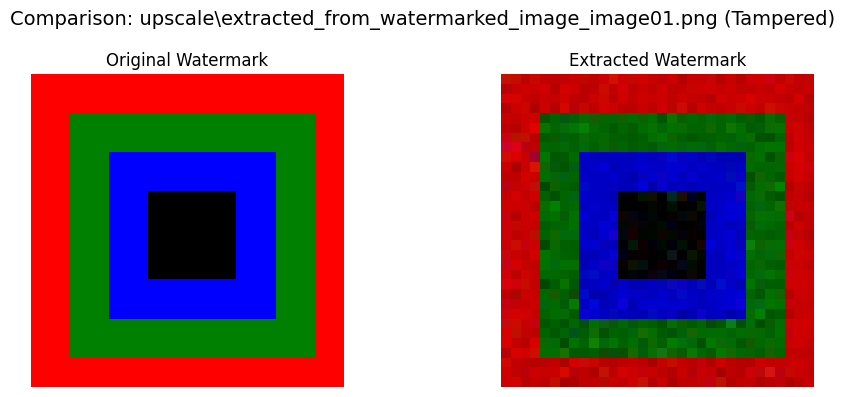

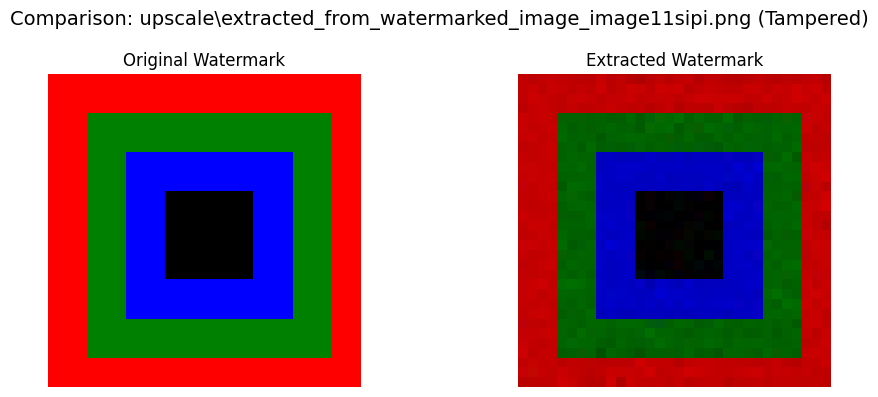

Authentication results saved to 'authentication_results.csv'.

=== Authentication Results ===
                                                       Image Name      PSNR     SSIM       CC Authentic
         bright05\extracted_from_watermarked_image_baboonsipi.png 12.489645 0.711104 0.999499  Tampered
            bright05\extracted_from_watermarked_image_image01.png 12.478308 0.529571 0.991596  Tampered
        bright05\extracted_from_watermarked_image_image11sipi.png 12.499236 0.717635 0.999495  Tampered
         bright06\extracted_from_watermarked_image_baboonsipi.png 14.414015 0.804235 0.999637  Tampered
            bright06\extracted_from_watermarked_image_image01.png 14.559034 0.618610 0.994573  Tampered
        bright06\extracted_from_watermarked_image_image11sipi.png 14.434933 0.808730 0.999634  Tampered
         bright07\extracted_from_watermarked_image_baboonsipi.png 16.910754 0.869347 0.999672  Tampered
            bright07\extracted_from_watermarked_image_image01.png 17.08807

In [50]:
import os
import cv2
import numpy as np
import pandas as pd
import threading
from queue import Queue
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

def authenticate_images(images_DIR, watermark_path, output_dir, psnr_threshold=30, ssim_threshold=0.95, cc_threshold=0.98):
    def calculate_metrics(image_path, original_watermark, queue):
        extracted_image = cv2.imread(image_path)
        image_name = os.path.relpath(image_path, images_DIR)

        if extracted_image is None:
            queue.put((image_name, None, None, None, "Error: Image not loaded"))
            return

        resized_watermark = cv2.resize(original_watermark, (extracted_image.shape[1], extracted_image.shape[0]))

        psnr_value = psnr(extracted_image, resized_watermark)
        ssim_value = ssim(extracted_image, resized_watermark, channel_axis=-1)
        correlation = np.corrcoef(extracted_image.flatten(), resized_watermark.flatten())[0, 1]

        is_authentic = (
            psnr_value >= psnr_threshold and
            ssim_value >= ssim_threshold and
            correlation >= cc_threshold
        )

        extracted_save_path = os.path.join(output_dir, f"extracted_{image_name.replace(os.sep, '_')}")
        os.makedirs(os.path.dirname(extracted_save_path), exist_ok=True)
        cv2.imwrite(extracted_save_path, extracted_image)

        queue.put((image_name, psnr_value, ssim_value, correlation, "Authentic" if is_authentic else "Tampered"))

    if not os.path.exists(watermark_path):
        raise FileNotFoundError(f"Watermark file not found: {watermark_path}")

    if not os.path.exists(images_DIR):
        raise FileNotFoundError(f"Image directory not found: {images_DIR}")

    os.makedirs(output_dir, exist_ok=True)
    original_watermark = cv2.imread(watermark_path)

    if original_watermark is None:
        raise ValueError("Original watermark could not be loaded.")

    image_paths = []
    for root, dirs, files in os.walk(images_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_paths.append(os.path.join(root, file))

    if len(image_paths) == 0:
        raise ValueError("No image files found in the specified directory or subdirectories.")

    data_queue = Queue()
    threads = []

    for image_path in image_paths:
        thread = threading.Thread(target=calculate_metrics, args=(image_path, original_watermark, data_queue))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    results = []
    while not data_queue.empty():
        results.append(data_queue.get())

    df = pd.DataFrame(results, columns=['Image Name', 'PSNR', 'SSIM', 'CC', 'Authentic']).sort_values('Image Name')

    for idx, row in df.iterrows():
        extracted_relative_path = row['Image Name'].replace(os.sep, '_')
        extracted_path = os.path.join(output_dir, f"extracted_{extracted_relative_path}")
        extracted_image = cv2.imread(extracted_path)

        if extracted_image is not None:
            plt.figure(figsize=(10, 4))
            plt.suptitle(f"Comparison: {row['Image Name']} ({row['Authentic']})", fontsize=14)

            plt.subplot(1, 2, 1)
            plt.title("Original Watermark")
            plt.imshow(cv2.cvtColor(cv2.resize(original_watermark, (extracted_image.shape[1], extracted_image.shape[0])), cv2.COLOR_BGR2RGB))
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Extracted Watermark")
            plt.imshow(cv2.cvtColor(extracted_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    return df

# Example usage
if __name__ == "__main__":
    images_DIR = "attack/extracted/"
    watermark_path = "watermark/Water.png"
    output_dir = "comparison_results"

    try:
        df = authenticate_images(images_DIR, watermark_path, output_dir)
        df.to_csv('authentication_results.csv', index=False)
        print("Authentication results saved to 'authentication_results.csv'.")
        print("\n=== Authentication Results ===")
        print(df.to_string(index=False))
    except Exception as e:
        print(f"Error: {e}")

 
    

     


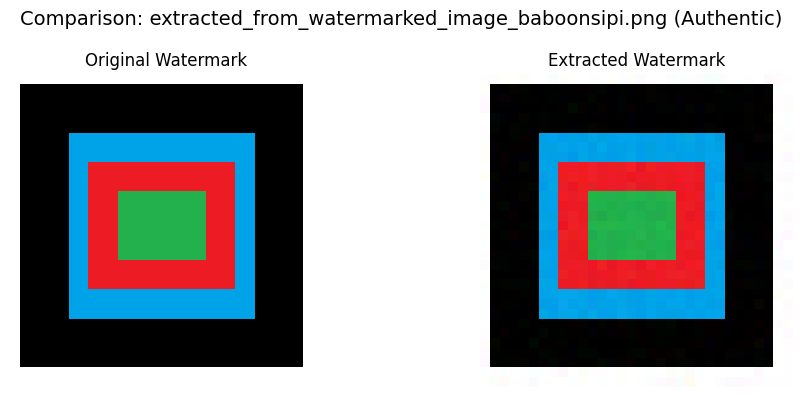

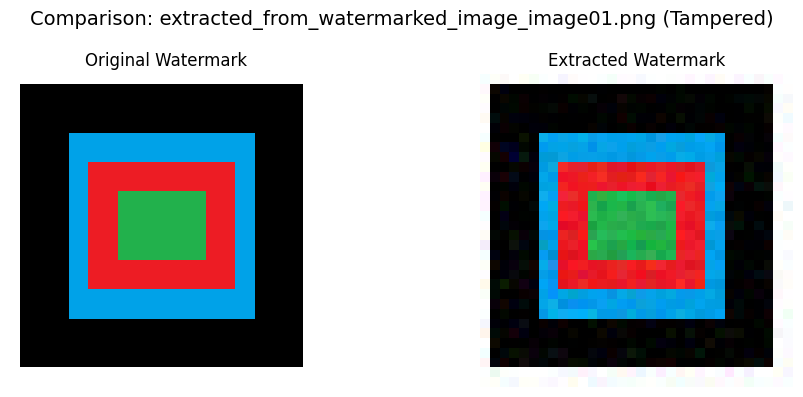

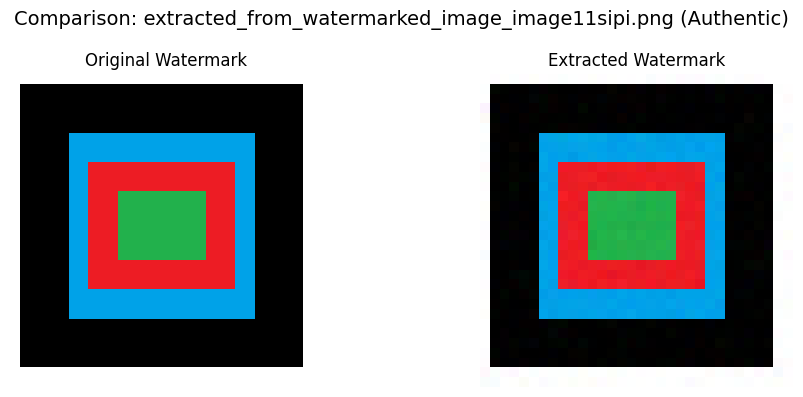

Authentication results saved to 'authentication_results.csv'.

=== Authentication Results ===
                                      Image Name      PSNR     SSIM       CC Authentic
 extracted_from_watermarked_image_baboonsipi.png 40.579850 0.985373 0.999793 Authentic
    extracted_from_watermarked_image_image01.png 31.805532 0.948656 0.998422  Tampered
extracted_from_watermarked_image_image11sipi.png 40.678103 0.984818 0.999798 Authentic


In [51]:
import os
import cv2
import numpy as np
import pandas as pd
import threading
from queue import Queue
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

def authenticate_images(images_DIR, watermark_path, output_dir, psnr_threshold=30, ssim_threshold=0.95, cc_threshold=0.98):
    def calculate_metrics(image_path, original_watermark, queue):
        extracted_image = cv2.imread(image_path)
        image_name = os.path.relpath(image_path, images_DIR)

        if extracted_image is None:
            queue.put((image_name, None, None, None, "Error: Image not loaded"))
            return

        resized_watermark = cv2.resize(original_watermark, (extracted_image.shape[1], extracted_image.shape[0]))

        psnr_value = psnr(extracted_image, resized_watermark)
        ssim_value = ssim(extracted_image, resized_watermark, channel_axis=-1)
        correlation = np.corrcoef(extracted_image.flatten(), resized_watermark.flatten())[0, 1]

        is_authentic = (
            psnr_value >= psnr_threshold and
            ssim_value >= ssim_threshold and
            correlation >= cc_threshold
        )

        extracted_save_path = os.path.join(output_dir, f"extracted_{image_name.replace(os.sep, '_')}")
        os.makedirs(os.path.dirname(extracted_save_path), exist_ok=True)
        cv2.imwrite(extracted_save_path, extracted_image)

        queue.put((image_name, psnr_value, ssim_value, correlation, "Authentic" if is_authentic else "Tampered"))

    if not os.path.exists(watermark_path):
        raise FileNotFoundError(f"Watermark file not found: {watermark_path}")

    if not os.path.exists(images_DIR):
        raise FileNotFoundError(f"Image directory not found: {images_DIR}")

    os.makedirs(output_dir, exist_ok=True)
    original_watermark = cv2.imread(watermark_path)

    if original_watermark is None:
        raise ValueError("Original watermark could not be loaded.")

    image_paths = []
    for root, dirs, files in os.walk(images_DIR):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_paths.append(os.path.join(root, file))

    if len(image_paths) == 0:
        raise ValueError("No image files found in the specified directory or subdirectories.")

    data_queue = Queue()
    threads = []

    for image_path in image_paths:
        thread = threading.Thread(target=calculate_metrics, args=(image_path, original_watermark, data_queue))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    results = []
    while not data_queue.empty():
        results.append(data_queue.get())

    df = pd.DataFrame(results, columns=['Image Name', 'PSNR', 'SSIM', 'CC', 'Authentic']).sort_values('Image Name')

    for idx, row in df.iterrows():
        extracted_relative_path = row['Image Name'].replace(os.sep, '_')
        extracted_path = os.path.join(output_dir, f"extracted_{extracted_relative_path}")
        extracted_image = cv2.imread(extracted_path)

        if extracted_image is not None:
            plt.figure(figsize=(10, 4))
            plt.suptitle(f"Comparison: {row['Image Name']} ({row['Authentic']})", fontsize=14)

            plt.subplot(1, 2, 1)
            plt.title("Original Watermark")
            plt.imshow(cv2.cvtColor(cv2.resize(original_watermark, (extracted_image.shape[1], extracted_image.shape[0])), cv2.COLOR_BGR2RGB))
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Extracted Watermark")
            plt.imshow(cv2.cvtColor(extracted_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    return df

# Example usage
if __name__ == "__main__":
    images_DIR = "extracted/"
    watermark_path = "watermark/WaterM.png"
    output_dir = "comparison_results"

    try:
        df = authenticate_images(images_DIR, watermark_path, output_dir)
        df.to_csv('authentication_results.csv', index=False)
        print("Authentication results saved to 'authentication_results.csv'.")
        print("\n=== Authentication Results ===")
        print(df.to_string(index=False))
    except Exception as e:
        print(f"Error: {e}")